In [1]:
import pandas as pd

co2_data = pd.read_csv('Co2.csv')
energy_data = pd.read_csv('Energy.csv')
sp500_data = pd.read_csv('sp500_data.csv')


### PRE-PROCESSING

In [2]:
#CO2 Data
co2_data['Date'] = pd.to_datetime(co2_data[['Year', 'Month', 'Day']])
co2_data.set_index('Date', inplace=True)

#Energy 
energy_data['Datetime'] = pd.to_datetime(energy_data['Date'] + ' ' + energy_data['Time'], format='%d/%m/%Y %H:%M:%S')
energy_data.drop(columns=['Date', 'Time'], inplace=True)
energy_data.set_index('Datetime', inplace=True)
for col in energy_data.columns:
    energy_data[col] = pd.to_numeric(energy_data[col], errors='coerce')


#S&P 500 Data
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'], format='%d/%m/%Y')
sp500_data.set_index('Date', inplace=True)

#Missing Valus
missing_values_co2 = co2_data.isnull().sum()
missing_values_energy = energy_data.isnull().sum()
missing_values_sp500 = sp500_data.isnull().sum()

# Displaying missing values
(missing_values_co2, missing_values_energy, missing_values_sp500)

(Year            0
 Month           0
 Day             0
 Decimal_Year    0
 CO2_ppm         0
 dtype: int64,
 Global_active_power      4069
 Global_reactive_power    4069
 Voltage                  4069
 Global_intensity         4069
 Sub_metering_1           4069
 Sub_metering_2           4069
 Sub_metering_3           4069
 dtype: int64,
 Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 dtype: int64)

#### Handle Missing Values

In [3]:
energy_data.interpolate(method='time', inplace=True)

# Forward fill
energy_data.fillna(method='ffill', inplace=True)

# If still missing values after forward fill, use backward fill
energy_data.fillna(method='bfill', inplace=True)

missing_values_energy = energy_data.isnull().sum()
missing_values_energy


C:\Users\muham\AppData\Local\Temp\ipykernel_11604\4082414868.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  energy_data.fillna(method='ffill', inplace=True)
C:\Users\muham\AppData\Local\Temp\ipykernel_11604\4082414868.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  energy_data.fillna(method='bfill', inplace=True)


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

#### Normalization

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

minmax_scaler = MinMaxScaler()
std_scaler = StandardScaler()

# CO2 Data
scaler = MinMaxScaler()
co2_data['CO2_ppm_scaled'] = scaler.fit_transform(co2_data[['CO2_ppm']])

# S&P 500 Data
sp500_data[['Open_scaled', 'High_scaled', 'Low_scaled', 'Close_scaled', 'Adj Close_scaled', 'Volume_scaled']] = \
    minmax_scaler.fit_transform(sp500_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])

# Energy Data
energy_data[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 
             'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']] = \
    std_scaler.fit_transform(energy_data[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 
                                         'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']])


In [5]:
energy_data_daily = energy_data.resample('D').mean()

#### Stationarization

In [6]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Function to check stationarity
def test_stationarity(ts):
    adf_result = adfuller(ts)
    return {
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Stationary': adf_result[1] < 0.05
    }

# CO2 Data - Log Transformation and Differencing
# Log Transformation and Differencing
co2_data['CO2_ppm_log'] = np.log(co2_data['CO2_ppm_scaled'] + 1)
co2_data['CO2_ppm_diff'] = co2_data['CO2_ppm_log'].diff().dropna()
co2_stationarity = test_stationarity(co2_data['CO2_ppm_diff'].dropna())

energy_data_daily['Global_active_power_log'] = np.log(energy_data_daily['Global_active_power'] + 1)
energy_data_daily['Global_active_power_diff'] = energy_data_daily['Global_active_power_log'].diff().dropna()
energy_stationarity = test_stationarity(energy_data_daily['Global_active_power_diff'].dropna())

# S&P 500 Data - Log Transformation and Differencing
sp500_data['Adj Close_log'] = np.log(sp500_data['Adj Close'] + 1)
sp500_data['Adj Close_diff'] = sp500_data['Adj Close_log'].diff().dropna()
sp500_stationarity = test_stationarity(sp500_data['Adj Close_diff'].dropna())

# Display stationarity results
(co2_stationarity, energy_stationarity, sp500_stationarity)


({'ADF Statistic': -12.670084380527369,
  'p-value': 1.2500244565984315e-23,
  'Stationary': True},
 {'ADF Statistic': -9.766279284478307,
  'p-value': 7.335279471736743e-17,
  'Stationary': True},
 {'ADF Statistic': -15.971416729085112,
  'p-value': 6.997641513474214e-29,
  'Stationary': True})

All datasets are stationary because their p-values are less than 0.05.

                                                Model Development                                           

####  ARIMA Configuration and Tuning

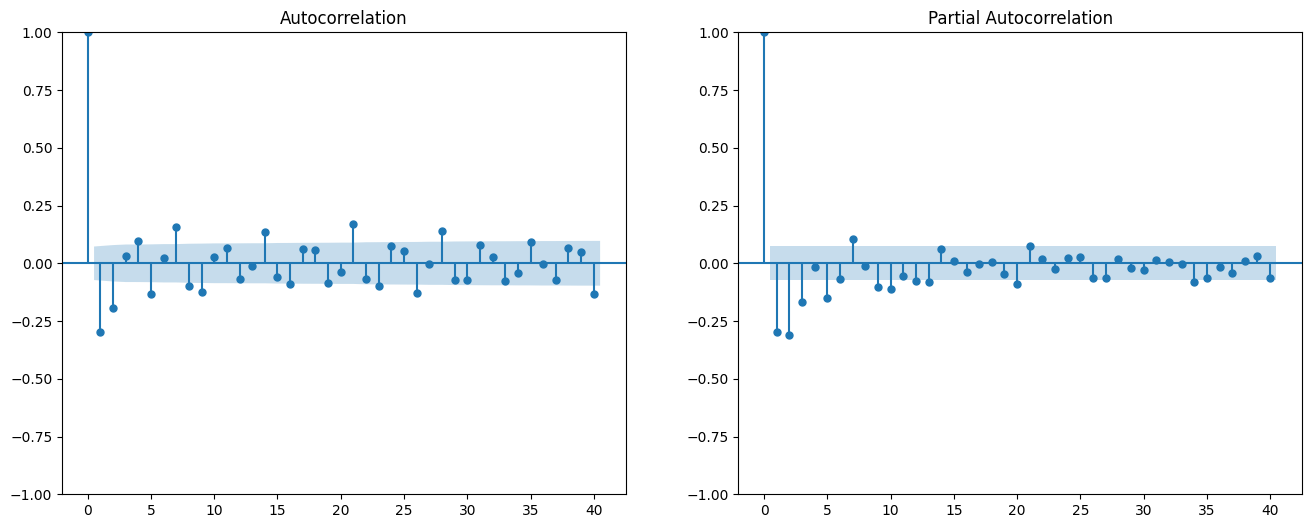

In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt


# Plot ACF and PACF for Energy Data
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(energy_data_daily['Global_active_power_diff'].dropna(), ax=axes[0], lags=40)
plot_pacf(energy_data_daily['Global_active_power_diff'].dropna(), ax=axes[1], lags=40)
plt.show()



MAE: 0.18209631317199612, MSE: 0.05240493777227695, RMSE: 0.22892124797029426


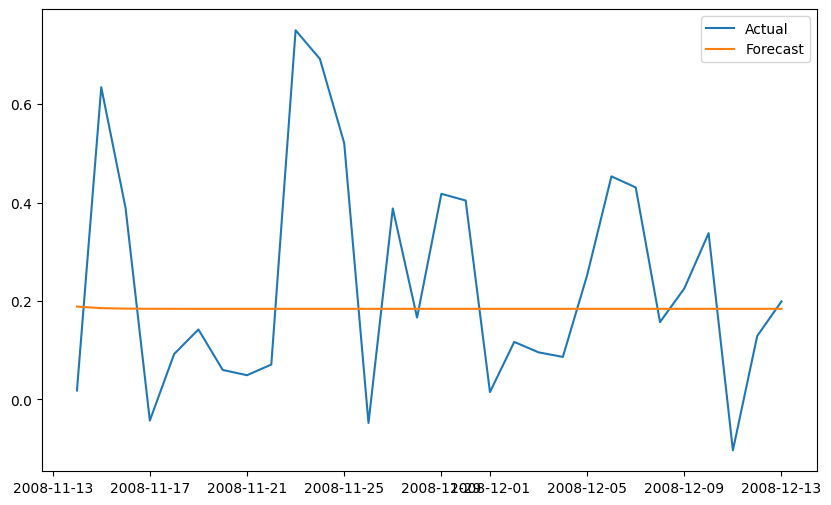

In [8]:
p, d, q = 1, 1, 1

# Fit the ARIMA model
model = ARIMA(energy_data_daily['Global_active_power_log'].dropna(), order=(p, d, q))
fitted_model = model.fit()

# Forecasting
forecast_steps = 30  
forecast = fitted_model.forecast(steps=forecast_steps)

# Evaluate the model
true_values = energy_data_daily['Global_active_power_log'][-forecast_steps:]
mae = mean_absolute_error(true_values, forecast)
mse = mean_squared_error(true_values, forecast)
rmse = np.sqrt(mse)

print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')

# Plot the forecast vs actual values
plt.figure(figsize=(10, 6))
plt.plot(true_values.index, true_values, label='Actual')
plt.plot(true_values.index, forecast, label='Forecast')
plt.legend()
plt.show()


### S&P Data 


ADF Statistic (S&P 500): -15.971416729085112, p-value: 6.997641513474214e-29


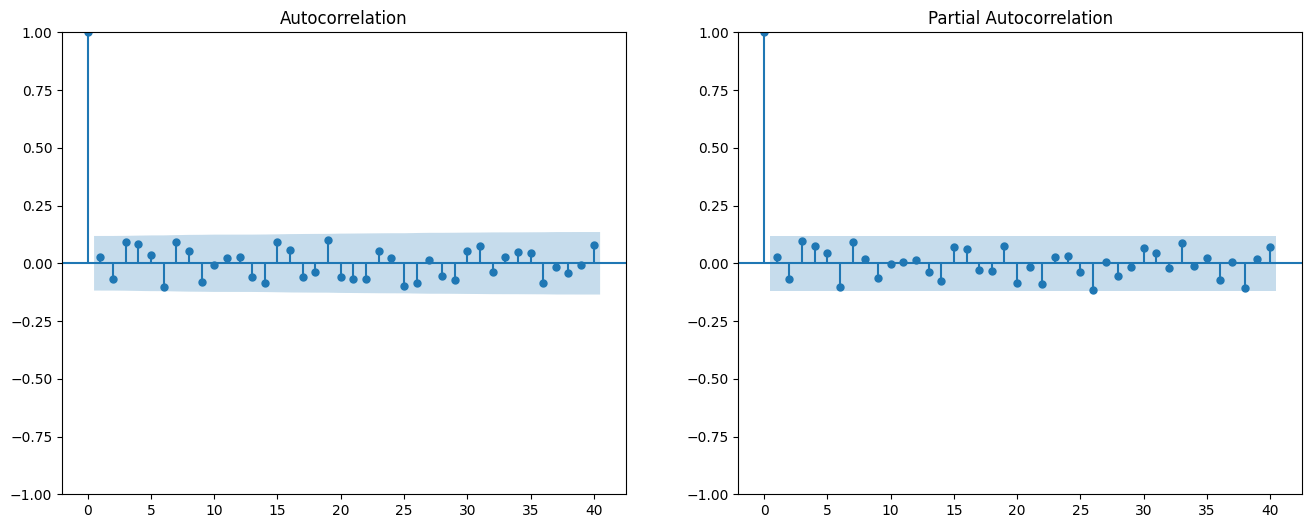

In [9]:
# ADF Test
sp500_stationarity = adfuller(sp500_data['Adj Close_diff'].dropna())
print(f"ADF Statistic (S&P 500): {sp500_stationarity[0]}, p-value: {sp500_stationarity[1]}")

# ACF/PACF Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(sp500_data['Adj Close_diff'].dropna(), ax=axes[0], lags=40)
plot_pacf(sp500_data['Adj Close_diff'].dropna(), ax=axes[1], lags=40)
plt.show()


f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


MAE (S&P 500): 0.1268762021115295, MSE (S&P 500): 0.021128304433866048, RMSE (S&P 500): 0.14535578569106236


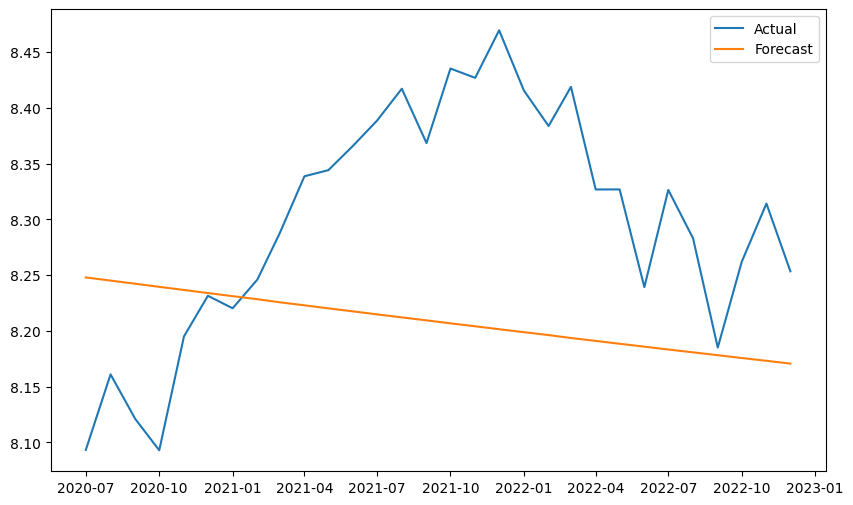

In [10]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA parameters based on analysis
p, d, q = 1, 0, 1

# Fit ARIMA model for S&P 500 data
model_sp500 = ARIMA(sp500_data['Adj Close_log'].dropna(), order=(p, d, q))
fitted_model_sp500 = model_sp500.fit()

# Forecasting       
forecast_steps = 30  # Adjust number of steps as necessary
forecast_sp500 = fitted_model_sp500.forecast(steps=forecast_steps)

# Evaluate the model
true_values_sp500 = sp500_data['Adj Close_log'][-forecast_steps:]
mae_sp500 = mean_absolute_error(true_values_sp500, forecast_sp500)
mse_sp500 = mean_squared_error(true_values_sp500, forecast_sp500)
rmse_sp500 = np.sqrt(mse_sp500)

print(f'MAE (S&P 500): {mae_sp500}, MSE (S&P 500): {mse_sp500}, RMSE (S&P 500): {rmse_sp500}')

# Plot the forecast vs actual values
plt.figure(figsize=(10, 6))
plt.plot(true_values_sp500.index, true_values_sp500, label='Actual')
plt.plot(true_values_sp500.index, forecast_sp500, label='Forecast')
plt.legend()
plt.show()


### CO2

C:\Users\muham\AppData\Local\Temp\ipykernel_11604\1321296532.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  co2_data.fillna(method='ffill', inplace=True)
C:\Users\muham\AppData\Local\Temp\ipykernel_11604\1321296532.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  co2_data.fillna(method='bfill', inplace=True)


ADF Statistic (CO2): -12.024202098573344, p-value: 2.975071078771754e-22


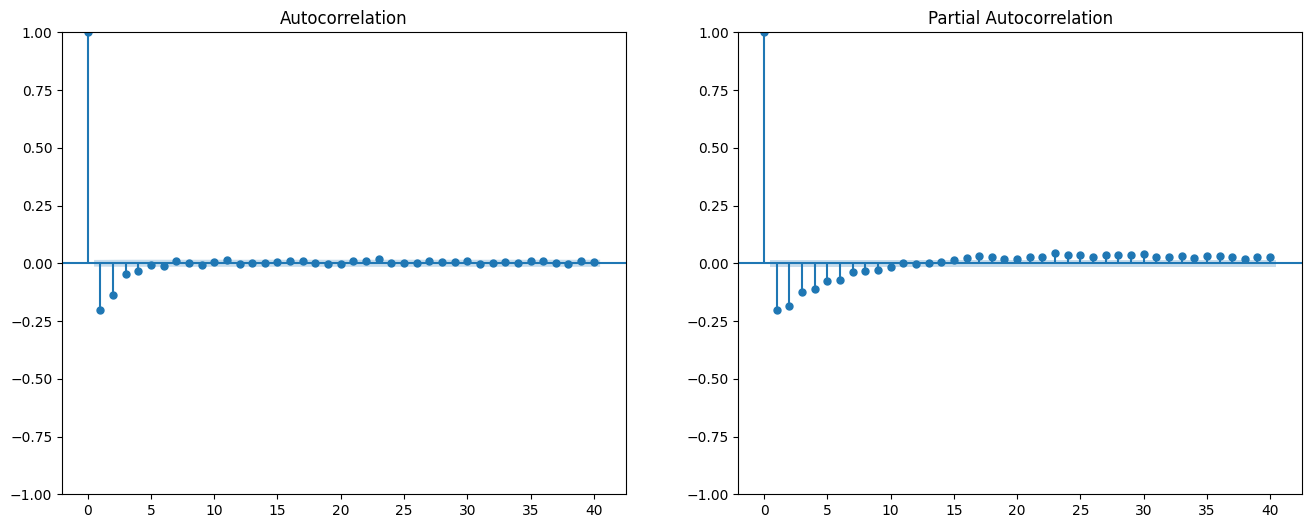

MAE (CO2): 0.004827017028177716, MSE (CO2): 3.5062367863404307e-05, RMSE (CO2): 0.005921348483530107


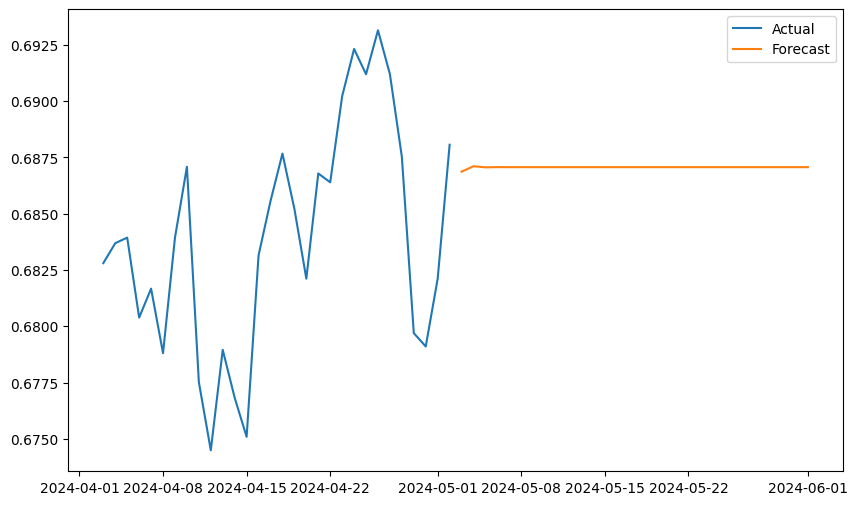

In [9]:
co2_data['Date'] = pd.to_datetime(co2_data[['Year', 'Month', 'Day']])
co2_data.set_index('Date', inplace=True)
co2_data = co2_data.asfreq('D')  # Setting frequency to daily

# Check for missing values and handle them
missing_values_co2 = co2_data.isnull().sum()
co2_data.fillna(method='ffill', inplace=True)
co2_data.fillna(method='bfill', inplace=True)

# Normalize the CO2 data using Min-Max scaling
scaler = MinMaxScaler()
co2_data['CO2_ppm_scaled'] = scaler.fit_transform(co2_data[['CO2_ppm']])

# Log Transformation and Differencing
co2_data['CO2_ppm_log'] = np.log(co2_data['CO2_ppm_scaled'] + 1)
co2_data['CO2_ppm_diff'] = co2_data['CO2_ppm_log'].diff().dropna()

# Check stationarity using the ADF test
co2_stationarity = adfuller(co2_data['CO2_ppm_diff'].dropna())
print(f"ADF Statistic (CO2): {co2_stationarity[0]}, p-value: {co2_stationarity[1]}")

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(co2_data['CO2_ppm_diff'].dropna(), ax=axes[0], lags=40)
plot_pacf(co2_data['CO2_ppm_diff'].dropna(), ax=axes[1], lags=40)
plt.show()

# ARIMA parameters based on analysis
p, d, q = 1, 1, 0  # Adjust to simpler parameters

# Fit ARIMA model for CO2 data
model_co2 = ARIMA(co2_data['CO2_ppm_log'].dropna(), order=(p, d, q))
fitted_model_co2 = model_co2.fit()

# Forecasting
forecast_steps = 30  # Adjust number of steps as necessary
forecast_co2 = fitted_model_co2.forecast(steps=forecast_steps)

# Ensure no NaN values in true and forecasted values
true_values_co2_clean = co2_data['CO2_ppm_log'][-forecast_steps:].dropna()
forecast_co2_clean = pd.Series(forecast_co2).dropna()

# Evaluate the model with clean data
mae_co2 = mean_absolute_error(true_values_co2_clean, forecast_co2_clean)
mse_co2 = mean_squared_error(true_values_co2_clean, forecast_co2_clean)
rmse_co2 = np.sqrt(mse_co2)

print(f'MAE (CO2): {mae_co2}, MSE (CO2): {mse_co2}, RMSE (CO2): {rmse_co2}')

# Plot the forecast vs actual values with clean data
plt.figure(figsize=(10, 6))
plt.plot(true_values_co2_clean.index, true_values_co2_clean, label='Actual')
plt.plot(forecast_co2_clean.index, forecast_co2_clean, label='Forecast')
plt.legend()
plt.show()

In [80]:
# Create a datetime index from Year, Month, and Day
co2_data['Date'] = pd.to_datetime(co2_data[['Year', 'Month', 'Day']])
co2_data.set_index('Date', inplace=True)

# Extract CO2_ppm for further processing
co2_ppm = co2_data['CO2_ppm']

# Normalization/Standardization using Min-Max scaling
co2_scaler = MinMaxScaler(feature_range=(0, 1))
co2_normalized = co2_scaler.fit_transform(co2_ppm.values.reshape(-1, 1))

# Stationarization
# Apply log transformation
co2_log = np.log(co2_normalized + 1)

# Apply differencing to make the series stationary
co2_diff = np.diff(co2_log.flatten())

# Check the preprocessed data
co2_diff[:5], co2_diff.mean(), co2_diff.std()

# Save preprocessed data
np.save('co2_diff.npy', co2_diff)


### ANN Design and Training

In [92]:
# Load preprocessed data
co2_diff = np.load('co2_diff.npy')

# Create sequences for ANN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Set sequence length and prepare sequences
sequence_length = 5
X, y = create_sequences(co2_diff, sequence_length)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the ANN model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def create_ann_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the model
input_dim = X_train.shape[1]
ann_model = create_ann_model(input_dim)
ann_model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))

# Evaluate the model
test_loss = ann_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")


Epoch 1/50
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.4575e-05 - val_loss: 1.3921e-05
Epoch 2/50
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.4002e-05 - val_loss: 1.4869e-05
Epoch 3/50
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.4276e-05 - val_loss: 1.3762e-05
Epoch 4/50
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.4200e-05 - val_loss: 1.5147e-05
Epoch 5/50
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.4347e-05 - val_loss: 1.4313e-05
Epoch 6/50
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3301e-05 - val_loss: 1.4297e-05
Epoch 7/50
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 2s 982us/step - loss: 1.4562e-05 - val_loss: 1.6230e-05
Epoch 8/50
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 2s 988us/step - loss: 1.4115e-05 - val_loss: 1.3727e-05
Epoch 9/50
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3529e-05 - val_loss: 1.4588e-05
Epoch 10/50
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3978e-05 - val_loss: 1.4298e-05
Epoch 11/50
1824/1824 ━━━━━━━━━━━━━

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Mean Squared Error (MSE): 1.371504769410519e-05
Mean Absolute Error (MAE): 0.0023232254649795665


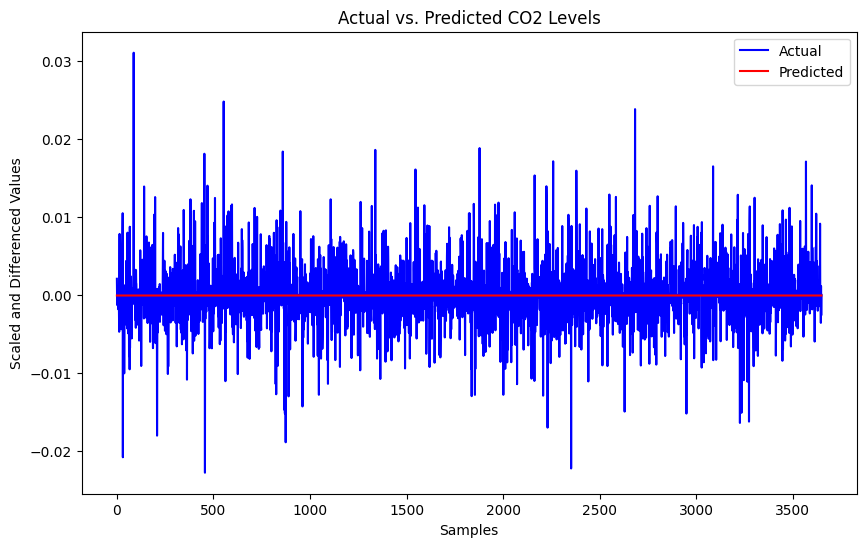

In [93]:

# Predict the test data
y_pred = ann_model.predict(X_test)

# Calculate additional evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


# Print metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")


# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs. Predicted CO2 Levels')
plt.xlabel('Samples')
plt.ylabel('Scaled and Differenced Values')
plt.legend()
plt.show()


### S&P 500 ANN Model


Architecture [64, 32]: Test Loss = 0.00034016670542769134
Architecture [128, 64, 32]: Test Loss = 0.00031296059023588896
Architecture [256, 128, 64]: Test Loss = 0.00029472331516444683
Results of different architectures:
Architecture (64, 32): Test Loss = 0.00034016670542769134
Architecture (128, 64, 32): Test Loss = 0.00031296059023588896
Architecture (256, 128, 64): Test Loss = 0.00029472331516444683
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Architecture [64, 32]:
Mean Squared Error (MSE): 0.0003135198255365039
Mean Absolute Error (MAE): 0.012055675751635853


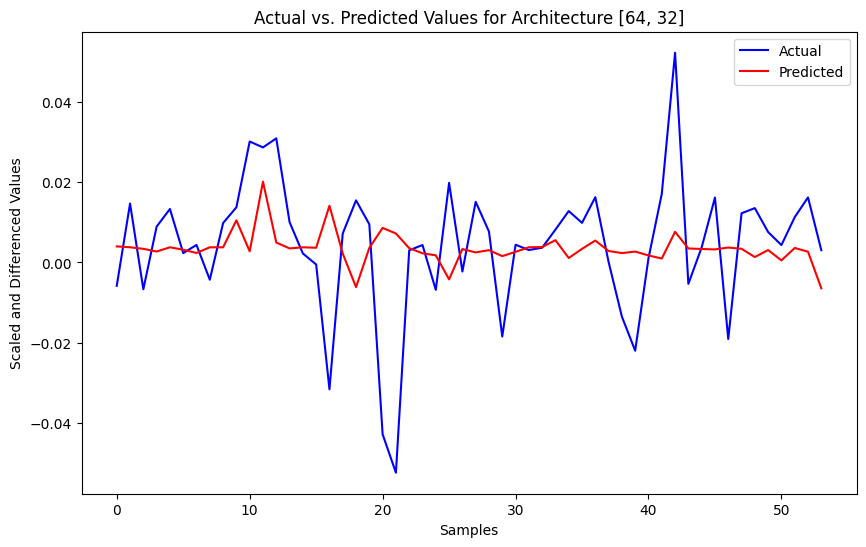

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Architecture [128, 64, 32]:
Mean Squared Error (MSE): 0.00031176731833531786
Mean Absolute Error (MAE): 0.012780387261312849


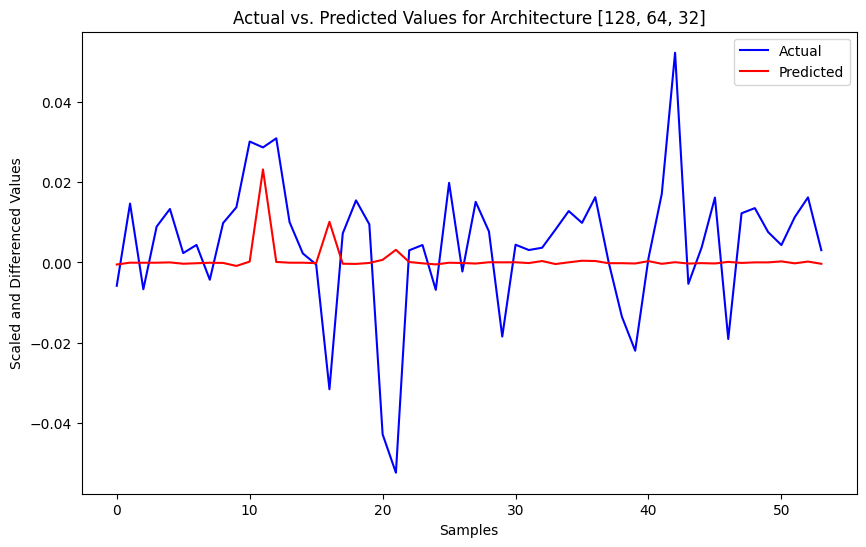

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Architecture [256, 128, 64]:
Mean Squared Error (MSE): 0.00030329555113604113
Mean Absolute Error (MAE): 0.012520626058948396


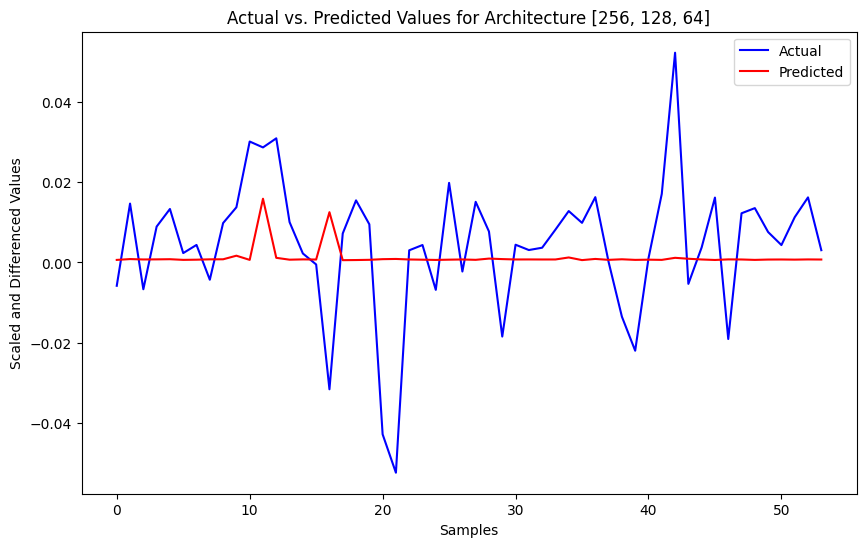

In [89]:
# Necessary imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load and preprocess the data
sp500_data = pd.read_csv('sp500_data.csv')
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'], format='%m/%d/%Y')
sp500_data.set_index('Date', inplace=True)
sp500_close = sp500_data['Adj Close']

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
sp500_normalized = scaler.fit_transform(sp500_close.values.reshape(-1, 1))

# Apply log transformation
sp500_log = np.log(sp500_normalized + 1)

# Apply differencing
sp500_diff = np.diff(sp500_log.flatten())

# Function to create sequences for ANN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Set sequence length and prepare sequences
sequence_length = 5
X, y = create_sequences(sp500_diff, sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to create an ANN model with varying layers and neurons
def create_ann_model(layers):
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))
    for neurons in layers:
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Experimenting with different architectures
architectures = [
    [64, 32],        # Two hidden layers
    [128, 64, 32],   # Three hidden layers
    [256, 128, 64],  # Three hidden layers with more neurons
]

# Train and evaluate different architectures
results = {}
for arch in architectures:
    model = create_ann_model(arch)
    history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    results[tuple(arch)] = test_loss
    print(f"Architecture {arch}: Test Loss = {test_loss}")

# Print the results
print("Results of different architectures:")
for arch, loss in results.items():
    print(f"Architecture {arch}: Test Loss = {loss}")


# Function to evaluate model
def evaluate_and_plot(model, X_test, y_test, arch):
    # Predict the test set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
  
    
    # Print evaluation metrics
    print(f"Architecture {arch}:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
   
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red')
    plt.title(f'Actual vs. Predicted Values for Architecture {arch}')
    plt.xlabel('Samples')
    plt.ylabel('Scaled and Differenced Values')
    plt.legend()
    plt.show()

# Train and evaluate different architectures
results = {}
for arch in architectures:
    model = create_ann_model(arch)
    history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    results[tuple(arch)] = test_loss
    evaluate_and_plot(model, X_test, y_test, arch)



### Energy ANN Model


f:\Pythan\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

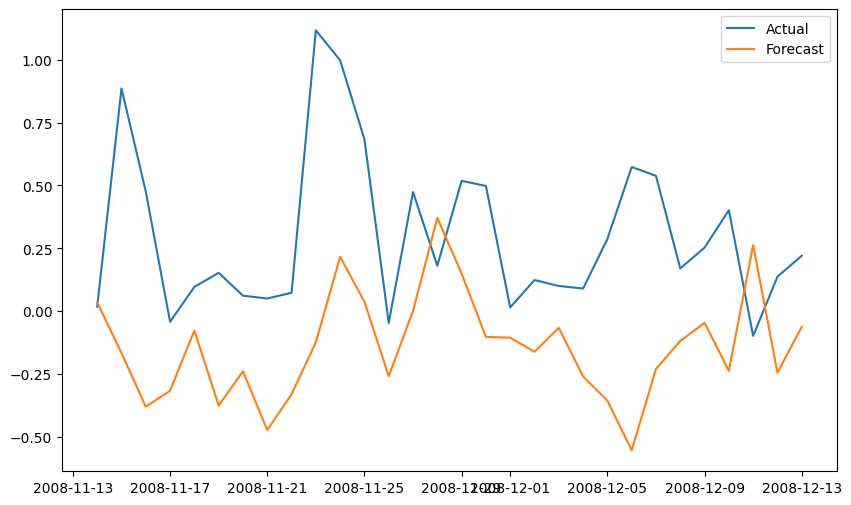

Energy - MAE: 0.4784582381409395, MSE: 0.3191948132022927, RMSE: 0.5649732853881613


In [77]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
import matplotlib.pyplot as plt

# Prepare data for ANN (Energy)
n_past = 30
global_active_power_log = energy_data_daily['Global_active_power_log'].values
X_energy, y_energy = [], []
for i in range(n_past, len(global_active_power_log)):
    X_energy.append(global_active_power_log[i-n_past:i])
    y_energy.append(global_active_power_log[i])
X_energy, y_energy = np.array(X_energy), np.array(y_energy)

# Build and train ANN model for Energy
model_energy = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(n_past,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model_energy.compile(optimizer='adam', loss='mean_squared_error')
model_energy.fit(X_energy, y_energy, epochs=100, validation_split=0.2, verbose=0)

# Forecasting Energy
forecast_steps = 30
X_input_energy = X_energy[-1].reshape(1, -1)
forecast_energy = []
for _ in range(forecast_steps):
    forecast_val = model_energy.predict(X_input_energy)
    forecast_energy.append(forecast_val[0, 0])
    X_input_energy = np.append(X_input_energy[:, 1:], forecast_val, axis=1)
forecast_energy = np.exp(np.array(forecast_energy)) - 1

# Plot the forecast vs actual values (Energy)
plt.figure(figsize=(10, 6))
plt.plot(energy_data_daily.index[-forecast_steps:], energy_data_daily['Global_active_power'][-forecast_steps:], label='Actual')
plt.plot(energy_data_daily.index[-forecast_steps:], forecast_energy, label='Forecast')
plt.legend()
plt.show()

# Evaluate model
mae_energy = mean_absolute_error(energy_data_daily['Global_active_power'].values[-forecast_steps:], forecast_energy)
mse_energy = mean_squared_error(energy_data_daily['Global_active_power'].values[-forecast_steps:], forecast_energy)
rmse_energy = np.sqrt(mse_energy)
print(f"Energy - MAE: {mae_energy}, MSE: {mse_energy}, RMSE: {rmse_energy}")


## SARIMA (Seasonal ARIMA):

In [102]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Load the datasets
sp500_data = pd.read_csv('sp500_data.csv')
co2_data = pd.read_csv('Co2.csv')
energy_data_daily = pd.read_csv('Energy.csv')  # Replace with your actual file

# Convert dates
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'], format='%m/%d/%Y')
co2_data['Date'] = pd.to_datetime(co2_data[['Year', 'Month', 'Day']])
energy_data_daily['Date'] = pd.to_datetime(energy_data_daily['Date'])

# Set indexes
sp500_data.set_index('Date', inplace=True)
co2_data.set_index('Date', inplace=True)
energy_data_daily.set_index('Date', inplace=True)

# Function to check stationarity
def test_stationarity(ts):
    adf_result = adfuller(ts)
    return {
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Stationary': adf_result[1] < 0.05
    }

# CO2 Data - Log Transformation and Differencing
co2_data['CO2_ppm_log'] = np.log(co2_data['CO2_ppm'] + 1)
co2_data['CO2_ppm_diff'] = co2_data['CO2_ppm_log'].diff().dropna()
co2_stationarity = test_stationarity(co2_data['CO2_ppm_diff'].dropna())


# S&P 500 Data - Log Transformation and Differencing
sp500_data['Adj Close_log'] = np.log(sp500_data['Adj Close'] + 1)
sp500_data['Adj Close_diff'] = sp500_data['Adj Close_log'].diff().dropna()
sp500_stationarity = test_stationarity(sp500_data['Adj Close_diff'].dropna())

# Display stationarity results
print('CO2 Data:', co2_stationarity)

print('S&P 500 Data:', sp500_stationarity)


C:\Users\muham\AppData\Local\Temp\ipykernel_5196\3528663232.py:13: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  energy_data_daily['Date'] = pd.to_datetime(energy_data_daily['Date'])


CO2 Data: {'ADF Statistic': -12.153628389936518, 'p-value': 1.5498989999417495e-22, 'Stationary': True}
S&P 500 Data: {'ADF Statistic': -15.971416729085112, 'p-value': 6.997641513474214e-29, 'Stationary': True}


#### CO2

CO2 Data: {'ADF Statistic': -12.153628389936518, 'p-value': 1.5498989999417495e-22, 'Stationary': True}
S&P 500 Data: {'ADF Statistic': -15.971416729085112, 'p-value': 6.997641513474214e-29, 'Stationary': True}


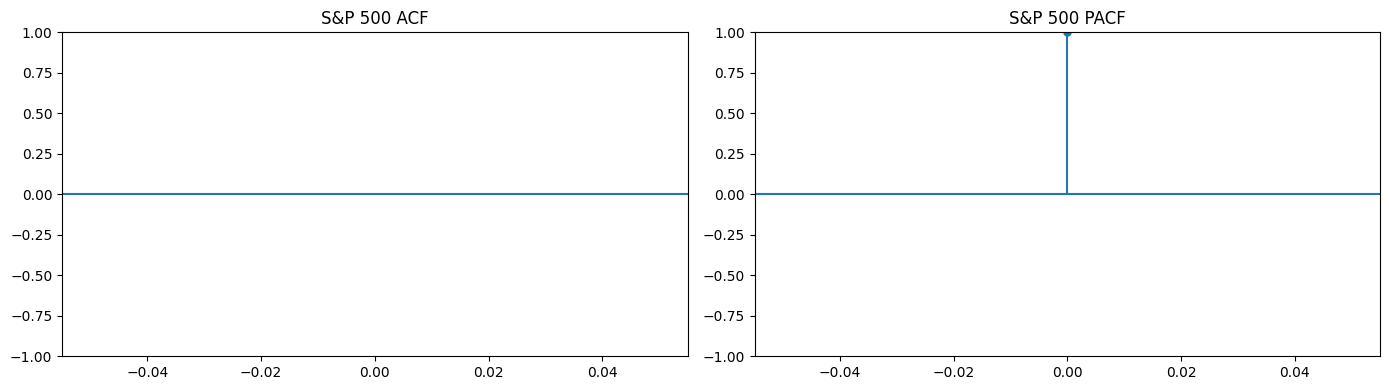

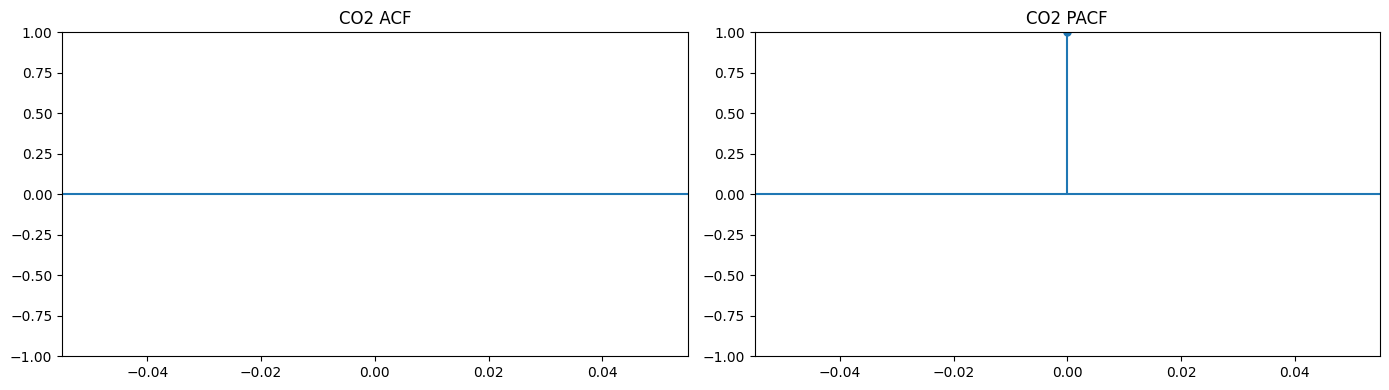

f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No support

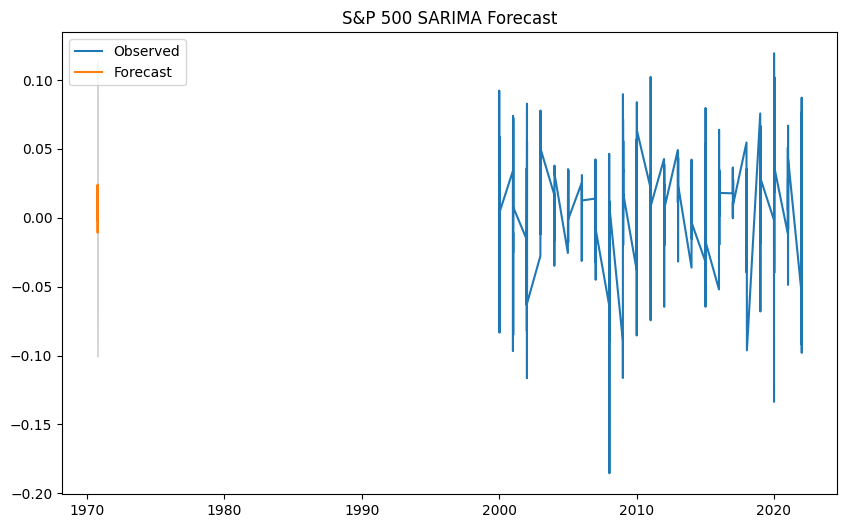

f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


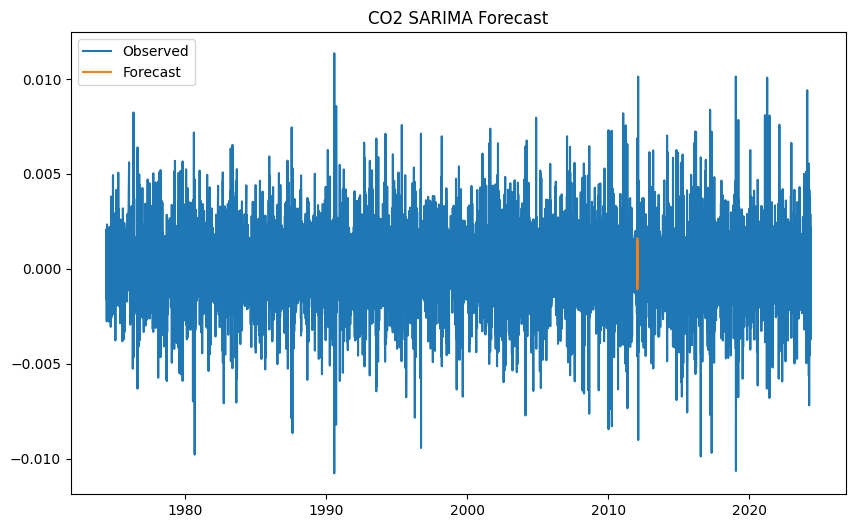

In [109]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Function to check stationarity
def test_stationarity(ts):
    adf_result = adfuller(ts)
    return {
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Stationary': adf_result[1] < 0.05
    }

# Load and preprocess the datasets (your original code)
sp500_data = pd.read_csv('sp500_data.csv')
co2_data = pd.read_csv('Co2.csv')


sp500_data['Date'] = pd.to_datetime(sp500_data['Date'], format='%m/%d/%Y')
co2_data['Date'] = pd.to_datetime(co2_data[['Year', 'Month', 'Day']])


sp500_data.set_index('Date', inplace=True)
co2_data.set_index('Date', inplace=True)


# Apply stationarity checks and transformations
co2_data['CO2_ppm_log'] = np.log(co2_data['CO2_ppm'] + 1)
co2_data['CO2_ppm_diff'] = co2_data['CO2_ppm_log'].diff().dropna()
co2_stationarity = test_stationarity(co2_data['CO2_ppm_diff'].dropna())

sp500_data['Adj Close_log'] = np.log(sp500_data['Adj Close'] + 1)
sp500_data['Adj Close_diff'] = sp500_data['Adj Close_log'].diff().dropna()
sp500_stationarity = test_stationarity(sp500_data['Adj Close_diff'].dropna())

print('CO2 Data:', co2_stationarity)

print('S&P 500 Data:', sp500_stationarity)

# SARIMA modeling
def plot_acf_pacf(ts, title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    plot_acf(ts, ax=axes[0], title=f'{title} ACF')
    plot_pacf(ts, ax=axes[1], title=f'{title} PACF')
    plt.tight_layout()
    plt.show()

# Function to train SARIMA and plot forecast
def train_and_forecast(series, order, seasonal_order, steps=12, title='Forecast'):
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    
    forecast = results.get_forecast(steps=steps)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    plt.figure(figsize=(10, 6))
    plt.plot(series, label='Observed')
    plt.plot(forecast_mean, label='Forecast')
    plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.3)
    plt.legend()
    plt.title(title)
    plt.show()

# Determine seasonal parameters from ACF and PACF plots
plot_acf_pacf(sp500_data['Adj Close_diff'], title='S&P 500')
plot_acf_pacf(co2_data['CO2_ppm_diff'], title='CO2')

# Example parameters - update based on ACF/PACF results
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12

# Train and forecast
train_and_forecast(sp500_data['Adj Close_diff'], order=(p, d, q), seasonal_order=(P, D, Q, s), title='S&P 500 SARIMA Forecast')
train_and_forecast(co2_data['CO2_ppm_diff'], order=(p, d, q), seasonal_order=(P, D, Q, s), title='CO2 SARIMA Forecast')


In [21]:
# Ensure to read the data correctly
energy_data = pd.read_csv('Energy.csv', sep=',', parse_dates={'DateTime': ['Date', 'Time']}, infer_datetime_format=True)
energy_data.set_index('DateTime', inplace=True)

# Convert the target column to numeric and drop any rows with missing values
energy_data['Global_active_power'] = pd.to_numeric(energy_data['Global_active_power'], errors='coerce')
energy_data.dropna(inplace=True)

# Apply a log transformation
energy_data['Global_active_power_log'] = np.log(energy_data['Global_active_power'] + 1)

# Compute the first difference to make the series stationary
energy_data['Global_active_power_diff'] = energy_data['Global_active_power_log'].diff()

# Drop any NaN values resulting from differencing
energy_data.dropna(subset=['Global_active_power_diff'], inplace=True)


C:\Users\muham\AppData\Local\Temp\ipykernel_5584\3217858126.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  energy_data = pd.read_csv('Energy.csv', sep=',', parse_dates={'DateTime': ['Date', 'Time']}, infer_datetime_format=True)
C:\Users\muham\AppData\Local\Temp\ipykernel_5584\3217858126.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  energy_data = pd.read_csv('Energy.csv', sep=',', parse_dates={'DateTime': ['Date', 'Time']}, infer_datetime_format=True)
C:\Users\muham\AppData\Local\Temp\ipykernel_5584\3217858126.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or 

#### Energy

In [22]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Function to check stationarity
def test_stationarity(ts):
    adf_result = adfuller(ts)
    return {
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Stationary': adf_result[1] < 0.05
    }



energy_data_daily['Global_active_power_log'] = np.log(energy_data_daily['Global_active_power'] + 1)
energy_data_daily['Global_active_power_diff'] = energy_data_daily['Global_active_power_log'].diff().dropna()
energy_stationarity = test_stationarity(energy_data_daily['Global_active_power_diff'].dropna())


print(f"Stationarity Test: {energy_stationarity}")


Stationarity Test: {'ADF Statistic': -9.766279284478307, 'p-value': 7.335279471736743e-17, 'Stationary': True}


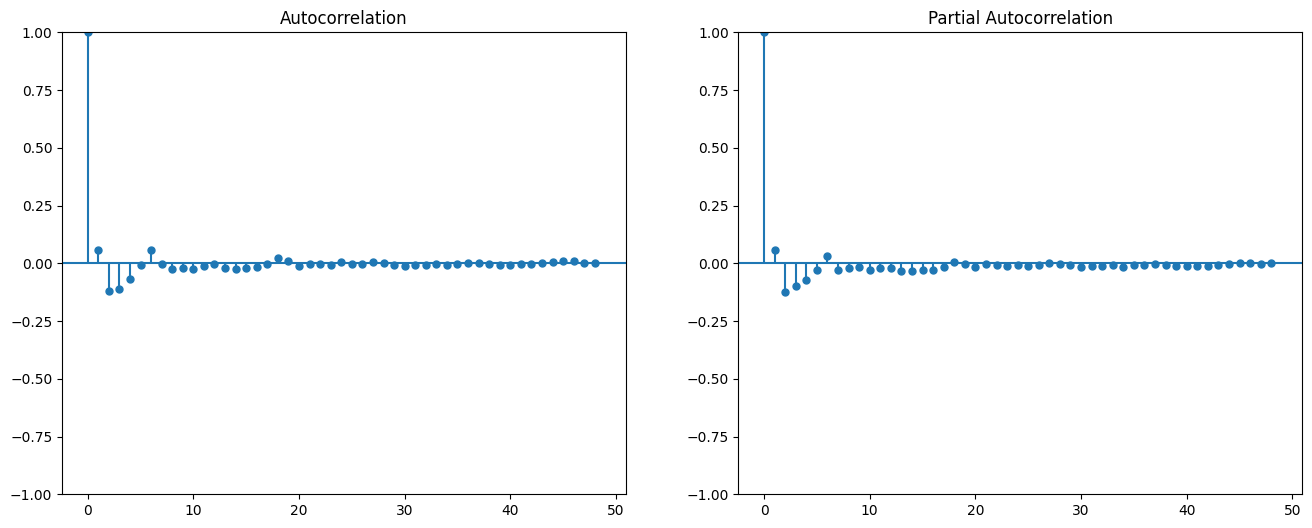

f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [23]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Plot ACF and PACF for seasonal analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(energy_data['Global_active_power_diff'].dropna(), ax=axes[0], lags=48)  # Adjust lags based on your data
plot_pacf(energy_data['Global_active_power_diff'].dropna(), ax=axes[1], lags=48)
plt.show()

# Set SARIMA parameters based on ACF and PACF analysis
p, d, q = 1, 1, 1  # non-seasonal parameters
P, D, Q, s = 1, 1, 1, 24  # seasonal parameters, adjust `s` according to the frequency of your data

# Fit the SARIMA model
model = SARIMAX(energy_data['Global_active_power_log'].dropna(), 
                order=(p, d, q), 
                seasonal_order=(P, D, Q, s))
fitted_model = model.fit(disp=False)

# Forecasting
forecast_steps = 30  # Adjust as needed
forecast = fitted_model.forecast(steps=forecast_steps)

# Evaluate the model
true_values = energy_data['Global_active_power_log'][-forecast_steps:]
mae = mean_absolute_error(true_values, forecast)
mse = mean_squared_error(true_values, forecast)
rmse = np.sqrt(mse)

print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')

# Plot the forecast vs actual values
plt.figure(figsize=(10, 6))
plt.plot(true_values.index, true_values, label='Actual')
plt.plot(true_values.index, forecast, label='Forecast')
plt.legend()
plt.show()


## Exponential Smoothing (ETS)

f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


CO2 Forecast - Mean Squared Error: 1.0253041481515308, Mean Absolute Error: 0.9100618163792878


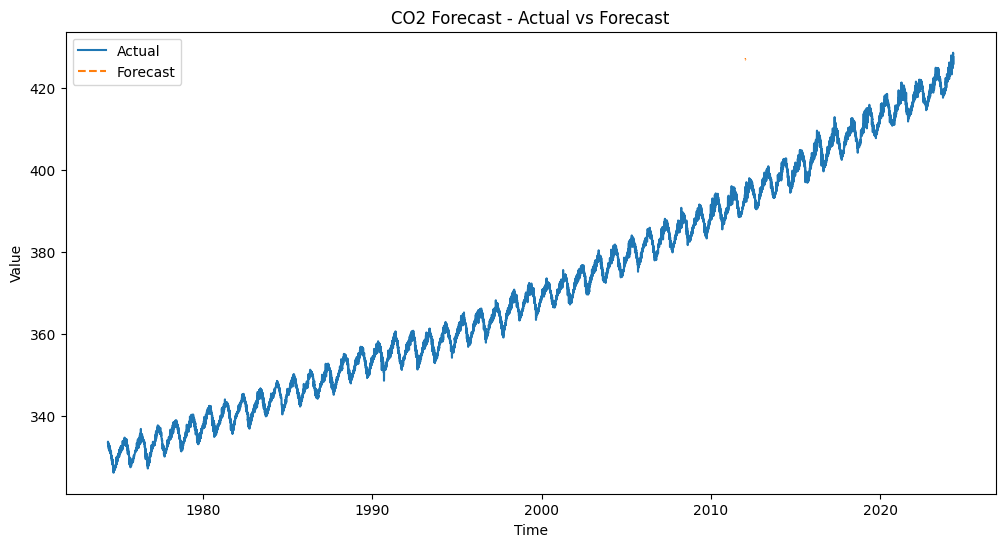

f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Energy Forecast - Mean Squared Error: 0.010632066537049375, Mean Absolute Error: 0.09235762829221612


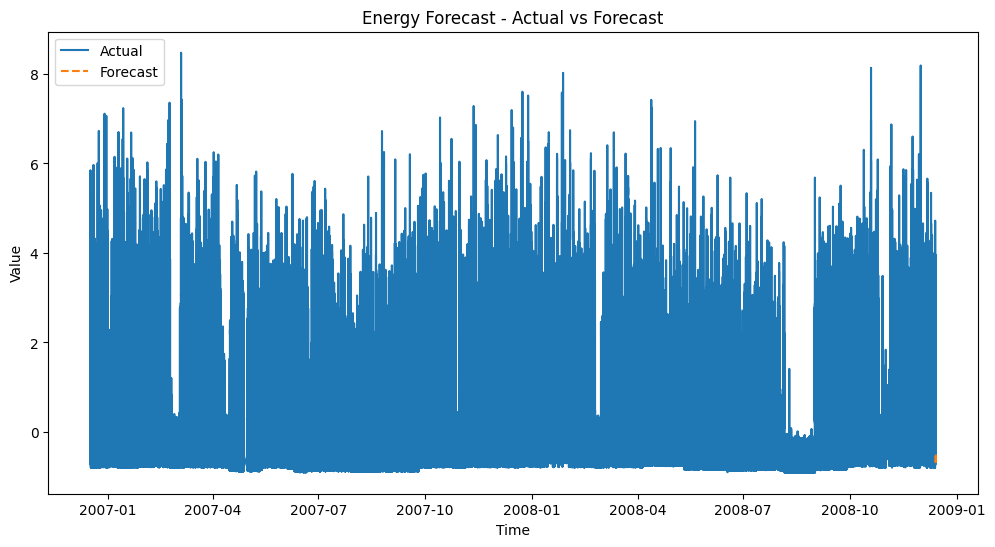

f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


S&P 500 Forecast - Mean Squared Error: 116577.07312495144, Mean Absolute Error: 267.1298645920349


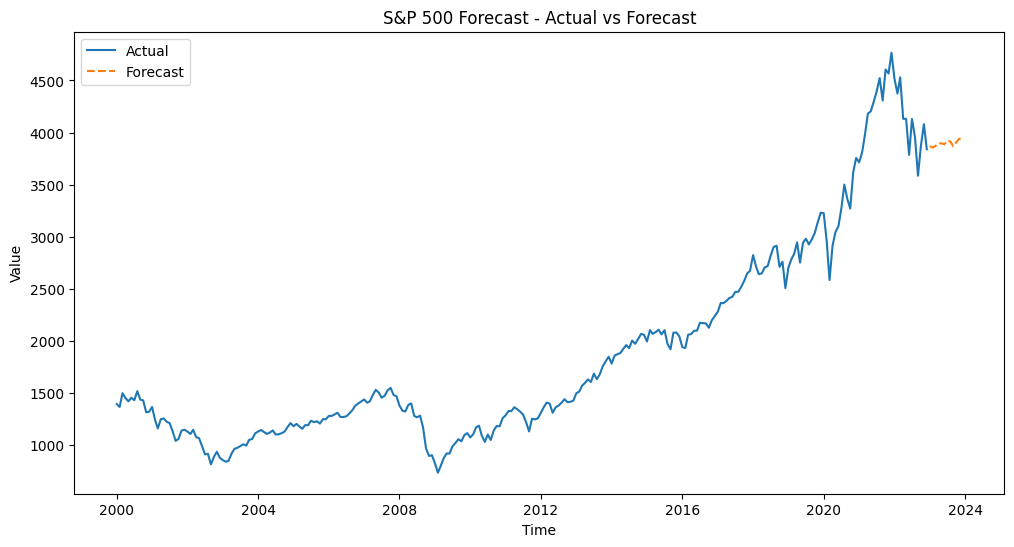

In [8]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


# Function to plot and evaluate models
def evaluate_forecast(model, data, forecast, title):
    # Calculate error metrics
    mse = mean_squared_error(data[-len(forecast):], forecast)
    mae = mean_absolute_error(data[-len(forecast):], forecast)

    # Print metrics
    print(f"{title} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}")

    # Plot actual vs forecasted data
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Actual')
    plt.plot(forecast, label='Forecast', linestyle='--')
    plt.title(f"{title} - Actual vs Forecast")
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# CO2 Data - Fitting Exponential Smoothing Model
co2_model = ExponentialSmoothing(
    co2_data['CO2_ppm'], 
    seasonal='add', 
    trend='add', 
    seasonal_periods=12
).fit()
co2_forecast = co2_model.forecast(steps=12)
evaluate_forecast(co2_model, co2_data['CO2_ppm'], co2_forecast, "CO2 Forecast")

# Energy Data - Fitting Exponential Smoothing Model
energy_model = ExponentialSmoothing(
    energy_data['Global_active_power'], 
    seasonal='add', 
    trend='add', 
    seasonal_periods=30
).fit()
energy_forecast = energy_model.forecast(steps=30)
evaluate_forecast(energy_model, energy_data['Global_active_power'], energy_forecast, "Energy Forecast")

# S&P 500 Data - Fitting Exponential Smoothing Model
sp500_model = ExponentialSmoothing(
    sp500_data['Adj Close'], 
    seasonal='add', 
    trend='add', 
    seasonal_periods=12
).fit()
sp500_forecast = sp500_model.forecast(steps=12)
evaluate_forecast(sp500_model, sp500_data['Adj Close'], sp500_forecast, "S&P 500 Forecast")


## Prophet

13:21:07 - cmdstanpy - INFO - Chain [1] start processing
13:21:20 - cmdstanpy - INFO - Chain [1] done processing


CO2 Forecast with Prophet - Mean Squared Error: 0.43597444925240747, Mean Absolute Error: 0.4959085692277625


f:\Pythan\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
f:\Pythan\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


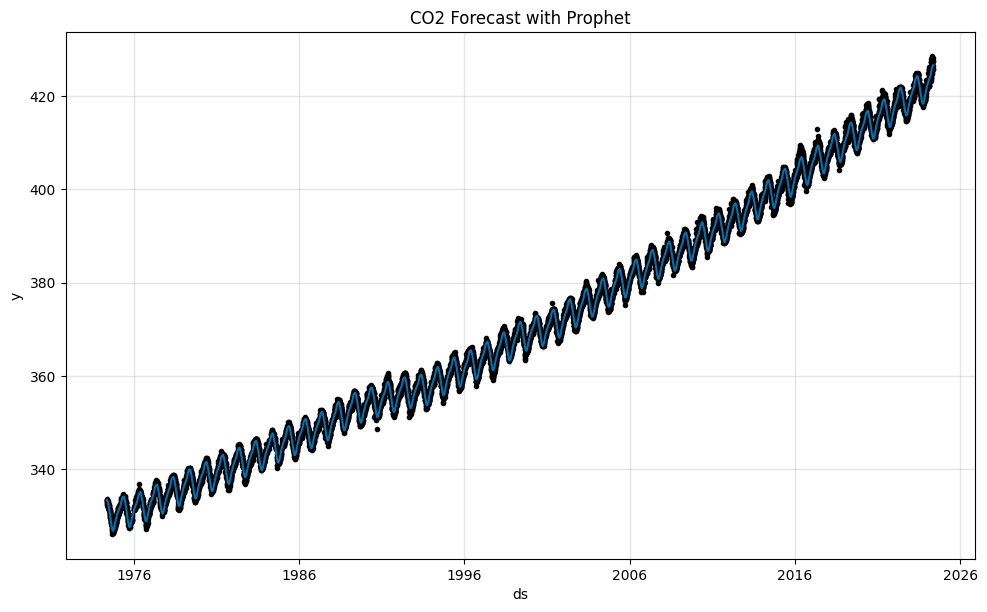

13:21:26 - cmdstanpy - INFO - Chain [1] start processing
13:21:26 - cmdstanpy - INFO - Chain [1] done processing


Energy Forecast with Prophet - Mean Squared Error: 0.0823592005429649, Mean Absolute Error: 0.21803803050286508


f:\Pythan\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
f:\Pythan\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


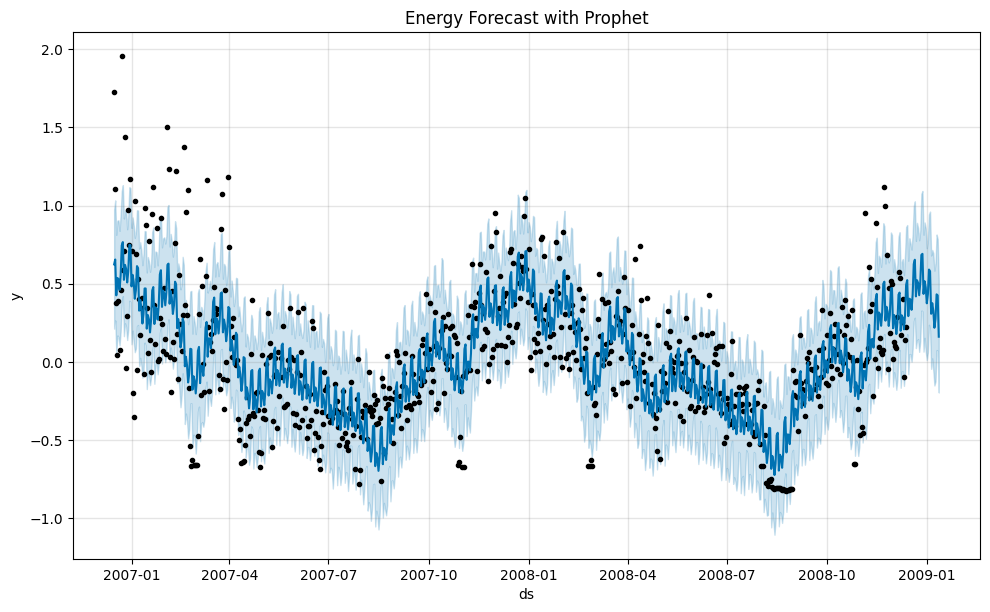

13:21:27 - cmdstanpy - INFO - Chain [1] start processing
13:21:27 - cmdstanpy - INFO - Chain [1] done processing
f:\Pythan\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
f:\Pythan\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


S&P 500 Forecast with Prophet - Mean Squared Error: 44179.51737656814, Mean Absolute Error: 153.9821195615888


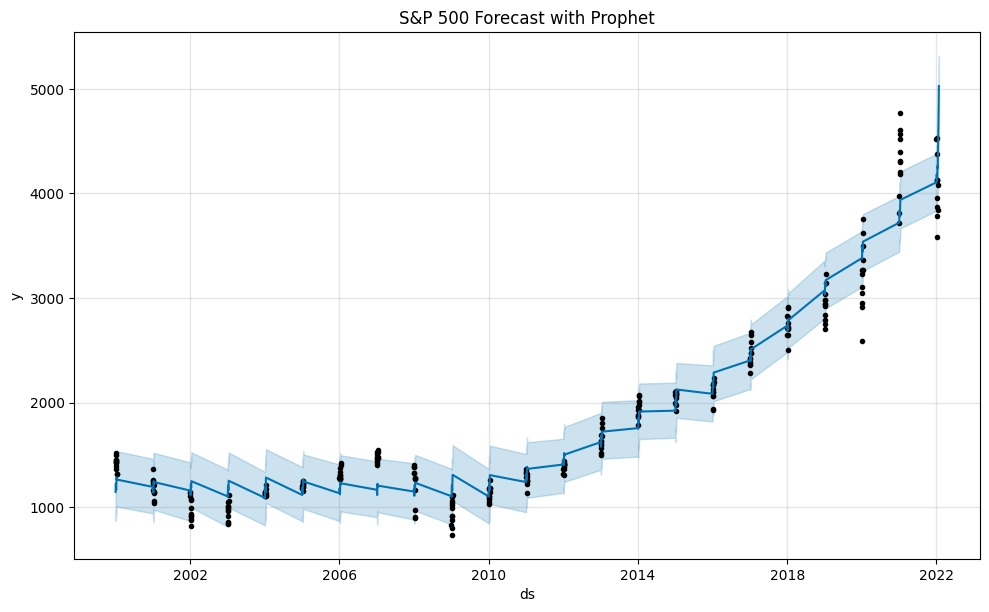

In [13]:
# Importing Prophet
from prophet import Prophet

# Preparing CO2 Data for Prophet
co2_prophet = co2_data.rename(columns={'Date': 'ds', 'CO2_ppm': 'y'})[['ds', 'y']]

# Preparing Energy Data for Prophet
energy_prophet = energy_data_daily.reset_index().rename(columns={'Datetime': 'ds', 'Global_active_power': 'y'})[['ds', 'y']]

# Preparing S&P 500 Data for Prophet
sp500_prophet = sp500_data.rename(columns={'Date': 'ds', 'Adj Close': 'y'})[['ds', 'y']]

# Function to fit, forecast, and evaluate Prophet model
def fit_and_evaluate_prophet(df, periods, title):
    # Initialize and fit the model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(df)
    
    # Make future dataframe and forecast
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    
    # Evaluation
    actual = df['y']
    predicted = forecast.loc[forecast['ds'] <= df['ds'].max(), 'yhat']
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    print(f"{title} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}")
    
    # Plot results
    model.plot(forecast)
    plt.title(title)
    plt.show()

# Apply Prophet Model to CO2 Data
fit_and_evaluate_prophet(co2_prophet, 12, "CO2 Forecast with Prophet")

# Apply Prophet Model to Energy Data
fit_and_evaluate_prophet(energy_prophet, 30, "Energy Forecast with Prophet")

# Apply Prophet Model to S&P 500 Data
fit_and_evaluate_prophet(sp500_prophet, 12, "S&P 500 Forecast with Prophet")

## Support Vector Regression (SVR)

C:\Users\muham\AppData\Local\Temp\ipykernel_12784\1190669060.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\muham\AppData\Local\Temp\ipykernel_12784\1190669060.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')
C:\Users\muham\AppData\Local\Temp\ipykernel_12784\1190669060.py:12: SettingWithCopyW

CO2 Forecast with SVR - Mean Squared Error: 9.792074236716667, Mean Absolute Error: 2.5290580858588427


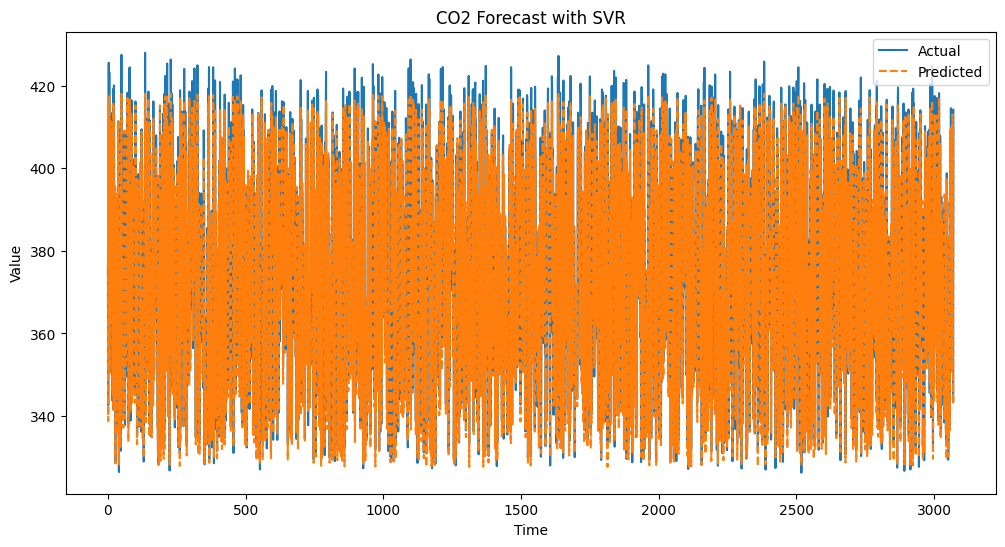

Energy Forecast with SVR - Mean Squared Error: 1.5831578817250216, Mean Absolute Error: 0.8198570699449723


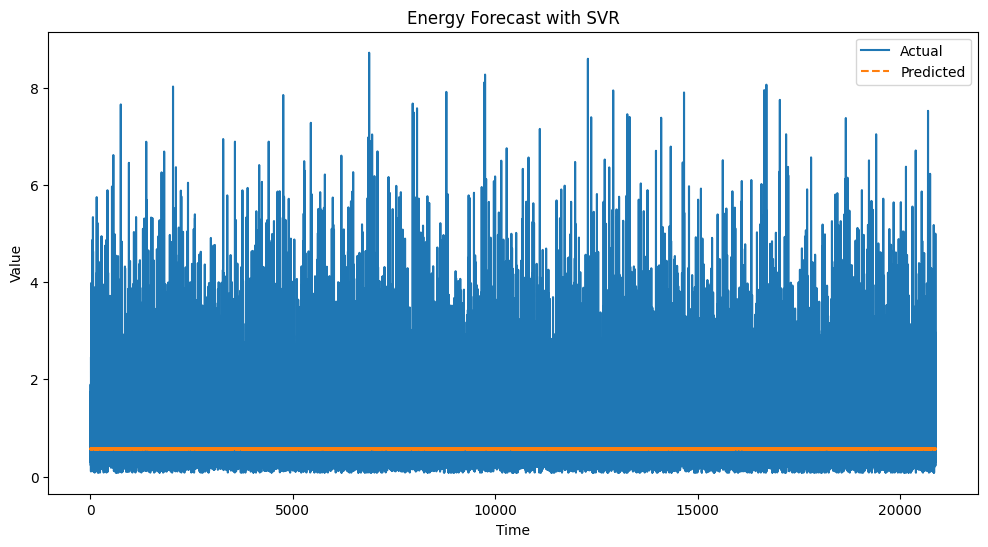

S&P 500 Forecast with SVR - Mean Squared Error: 346281.71710937563, Mean Absolute Error: 407.3313532245516


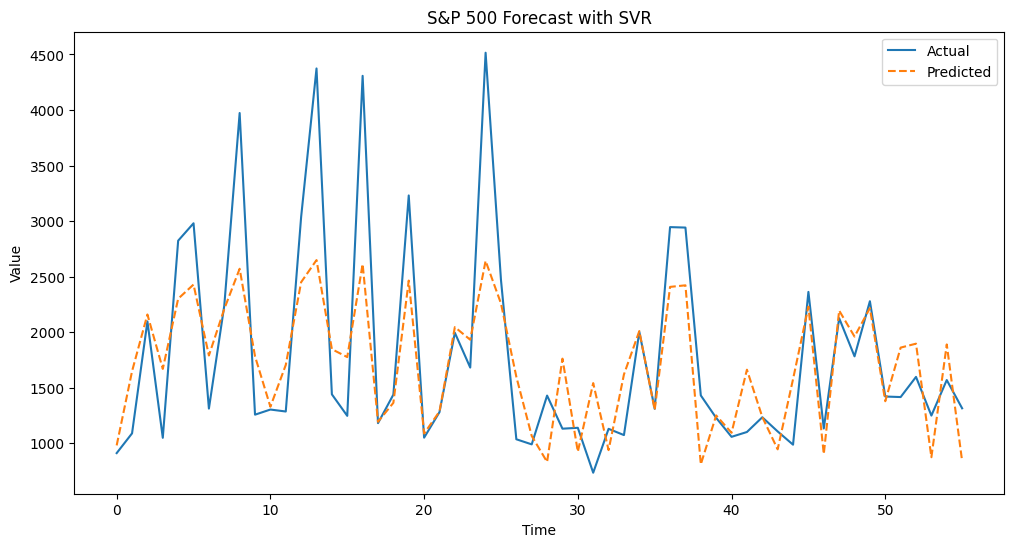

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Function to clean data
def clean_data(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(inplace=True)
    return df

# Load data (update file paths as needed)
co2_data = pd.read_csv('Co2.csv')
energy_data = pd.read_csv('Energy.csv')
sp500_data = pd.read_csv('sp500_data.csv')

# Prepare CO2 Data for SVR
co2_data['Date'] = pd.to_datetime(co2_data[['Year', 'Month', 'Day']])
co2_data.set_index('Date', inplace=True)
co2_data = clean_data(co2_data[['CO2_ppm']], ['CO2_ppm'])

# Prepare Energy Data for SVR
energy_data['Datetime'] = pd.to_datetime(energy_data['Date'] + ' ' + energy_data['Time'], format='%d/%m/%Y %H:%M:%S')
energy_data.set_index('Datetime', inplace=True)
energy_data = clean_data(energy_data[['Global_active_power']], ['Global_active_power'])

# Prepare S&P 500 Data for SVR
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'], format='%d/%m/%Y')
sp500_data.set_index('Date', inplace=True)
sp500_data = clean_data(sp500_data[['Adj Close']], ['Adj Close'])

# Function to train and evaluate SVR with conditional sampling
def train_and_evaluate_svr(df, title, sample_frac=1.0, cv_folds=3):
    # Sample data to reduce size if sample_frac < 1
    if sample_frac < 1.0:
        df = df.sample(frac=sample_frac, random_state=42)
    
    X = df.index.factorize()[0].reshape(-1, 1)  # Using the index as the feature
    y = df.values.ravel()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # SVR with reduced grid search space
    param_grid = {'C': [1, 10], 'gamma': ['scale'], 'kernel': ['linear']}
    grid_search = GridSearchCV(SVR(), param_grid, cv=cv_folds)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Predict and evaluate
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{title} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_test)), y_test, label='Actual')
    plt.plot(range(len(y_pred)), y_pred, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Apply SVR to CO2 Data without sampling
train_and_evaluate_svr(co2_data, "CO2 Forecast with SVR")

# Apply SVR to Energy Data with sampling
train_and_evaluate_svr(energy_data, "Energy Forecast with SVR", sample_frac=0.1)

# Apply SVR to S&P 500 Data without sampling
train_and_evaluate_svr(sp500_data, "S&P 500 Forecast with SVR")


## Long Short-Term Memory (LSTM):

Epoch 1/10


f:\Pythan\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0663
Epoch 2/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041
Epoch 3/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033
Epoch 4/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0030
Epoch 5/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0028
Epoch 6/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0023
Epoch 7/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0020
Epoch 8/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018
Epoch 9/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018
Epoch 10/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
CO2 Forecast with LSTM - Mean Squared Error: 1.005047097431729, Mean Absolute Error: 0.7096390404716766


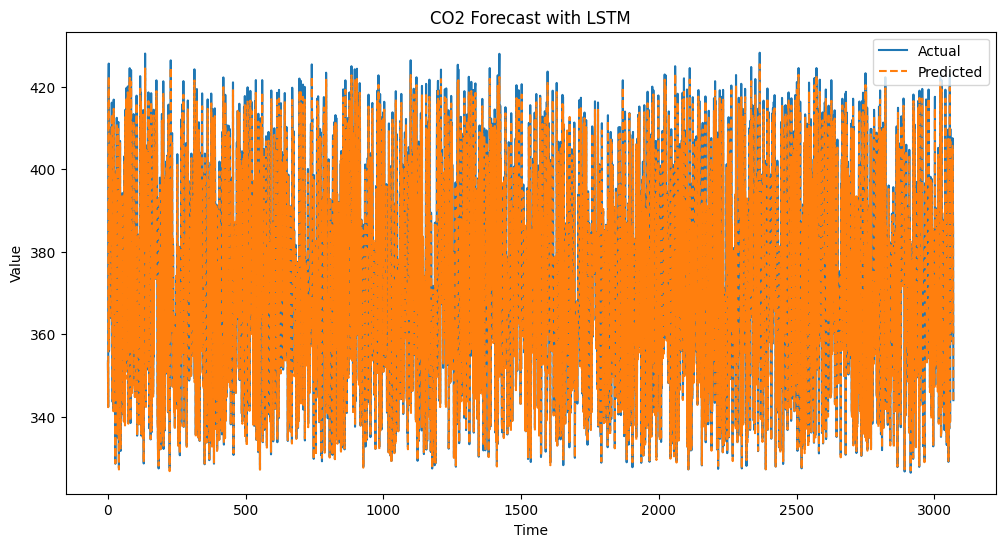

Epoch 1/10


f:\Pythan\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26113/26113 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.0011
Epoch 2/10
26113/26113 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - loss: 8.8172e-04
Epoch 3/10
26113/26113 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 8.6435e-04
Epoch 4/10
26113/26113 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 8.6339e-04
Epoch 5/10
26113/26113 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 8.4414e-04
Epoch 6/10
26113/26113 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - loss: 8.3327e-04
Epoch 7/10
26113/26113 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 8.3065e-04
Epoch 8/10
26113/26113 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - loss: 8.3653e-04
Epoch 9/10
26113/26113 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - loss: 8.4312e-04
Epoch 10/10
26113/26113 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - loss: 8.2827e-04
6529/6529 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Energy Forecast with LSTM - Mean Squared Error: 0.07596359554821132, Mean Absolute Error: 0.11163983263324843


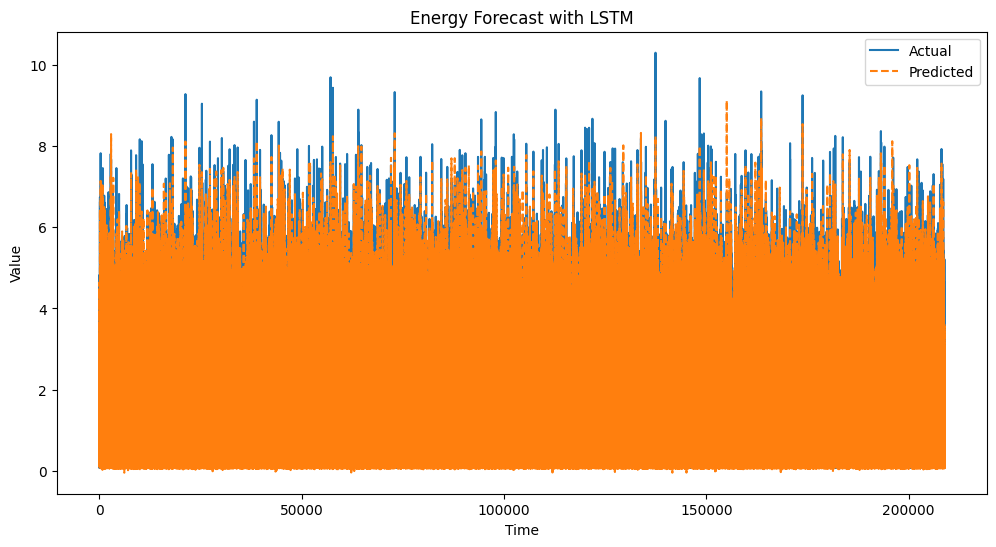

Epoch 1/10


f:\Pythan\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1629
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1308 
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0937 
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0838 
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0654 
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0452 
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0290 
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0209 
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
S&P 500 Forecast with LSTM - Mean Squared Error: 57554.09903033415, Mean Absolute Error: 194.2934315324147


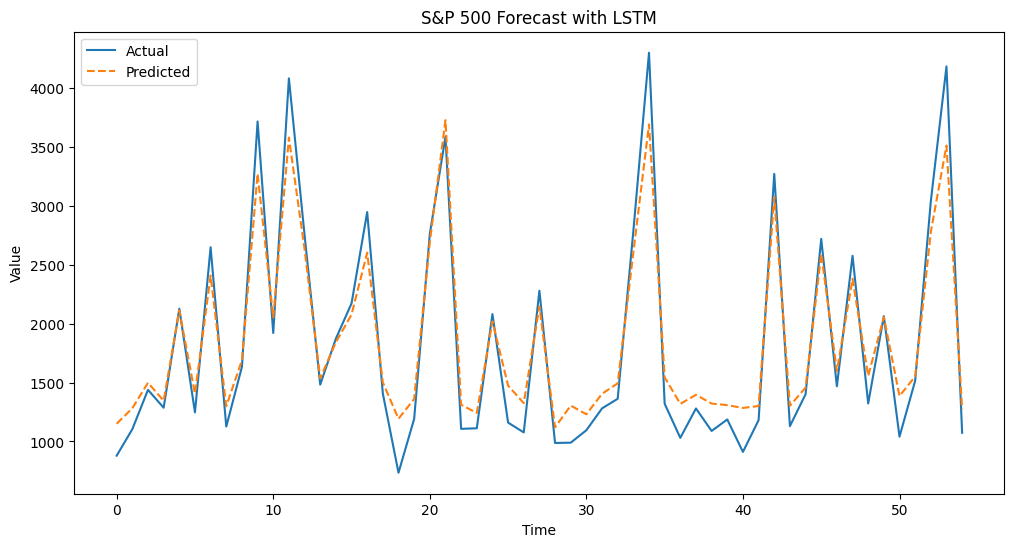

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Function to clean data
def clean_data(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(inplace=True)
    return df

# Load data (update file paths as needed)
co2_data = pd.read_csv('Co2.csv')
energy_data = pd.read_csv('Energy.csv')
sp500_data = pd.read_csv('sp500_data.csv')

# Function to prepare the data for LSTM
def prepare_lstm_data(df, feature, lookback=5):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[feature]])
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape to [samples, timesteps, features]
    return X, y, scaler

# Function to create and train an LSTM model
def train_lstm_model(X_train, y_train, input_shape, epochs=10, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# Function to evaluate the model and plot results
def evaluate_lstm_model(model, X_test, y_test, scaler, title):
    y_pred = model.predict(X_test)
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_scaled = scaler.inverse_transform(y_pred)
    mse = mean_squared_error(y_test_scaled, y_pred_scaled)
    mae = mean_absolute_error(y_test_scaled, y_pred_scaled)
    print(f"{title} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_scaled, label='Actual')
    plt.plot(y_pred_scaled, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Example usage for CO2 Data
co2_data['Date'] = pd.to_datetime(co2_data[['Year', 'Month', 'Day']])
co2_data.set_index('Date', inplace=True)
co2_data = clean_data(co2_data, ['CO2_ppm'])  # Clean the data
X_co2, y_co2, scaler_co2 = prepare_lstm_data(co2_data, 'CO2_ppm')
X_train_co2, X_test_co2, y_train_co2, y_test_co2 = train_test_split(X_co2, y_co2, test_size=0.2, random_state=42)
lstm_model_co2 = train_lstm_model(X_train_co2, y_train_co2, (X_train_co2.shape[1], 1))
evaluate_lstm_model(lstm_model_co2, X_test_co2, y_test_co2, scaler_co2, "CO2 Forecast with LSTM")

# Example usage for Energy Data
energy_data['Datetime'] = pd.to_datetime(energy_data['Date'] + ' ' + energy_data['Time'], format='%d/%m/%Y %H:%M:%S')
energy_data.set_index('Datetime', inplace=True)
energy_data = clean_data(energy_data, ['Global_active_power'])  # Clean the data
X_energy, y_energy, scaler_energy = prepare_lstm_data(energy_data, 'Global_active_power')
X_train_energy, X_test_energy, y_train_energy, y_test_energy = train_test_split(X_energy, y_energy, test_size=0.2, random_state=42)
lstm_model_energy = train_lstm_model(X_train_energy, y_train_energy, (X_train_energy.shape[1], 1))
evaluate_lstm_model(lstm_model_energy, X_test_energy, y_test_energy, scaler_energy, "Energy Forecast with LSTM")

# Example usage for S&P 500 Data
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'], format='%d/%m/%Y')
sp500_data.set_index('Date', inplace=True)
sp500_data = clean_data(sp500_data, ['Adj Close'])  # Clean the data
X_sp500, y_sp500, scaler_sp500 = prepare_lstm_data(sp500_data, 'Adj Close')
X_train_sp500, X_test_sp500, y_train_sp500, y_test_sp500 = train_test_split(X_sp500, y_sp500, test_size=0.2, random_state=42)
lstm_model_sp500 = train_lstm_model(X_train_sp500, y_train_sp500, (X_train_sp500.shape[1], 1))
evaluate_lstm_model(lstm_model_sp500, X_test_sp500, y_test_sp500, scaler_sp500, "S&P 500 Forecast with LSTM")


## Hybrid Models Integration

f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Epoch 1/10


f:\Pythan\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - loss: 0.0107
Epoch 2/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 1.9883e-05
Epoch 3/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 1.7563e-05
Epoch 4/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 1.8679e-05
Epoch 5/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 1.8158e-05
Epoch 6/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 1.7471e-05
Epoch 7/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.7993e-05
Epoch 8/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 1.9301e-05
Epoch 9/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 2.0513e-05
Epoch 10/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 1.9170e-05
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
CO2 Hybrid ARIMA-ANN Forecast - Mean Squared Error: 2.99364394514777e-10, Mean Absolute Error: 1.259104089353782e-05


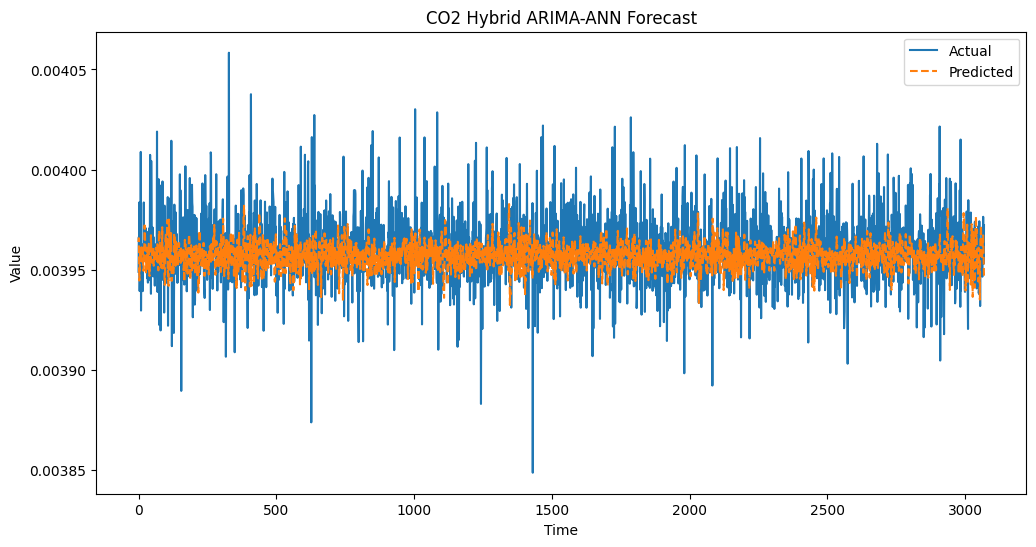

In [12]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Load data (update file paths as needed)
co2_data = pd.read_csv('Co2.csv')

# Min-Max scaling for CO2 data
scaler = MinMaxScaler()
co2_data['CO2_ppm_scaled'] = scaler.fit_transform(co2_data[['CO2_ppm']])

# Function to check stationarity
def test_stationarity(ts):
    adf_result = adfuller(ts)
    return {
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Stationary': adf_result[1] < 0.05
    }

# Log Transformation and Differencing
co2_data['CO2_ppm_log'] = np.log(co2_data['CO2_ppm_scaled'] + 1)
co2_data['CO2_ppm_diff'] = co2_data['CO2_ppm_log'].diff().dropna()
co2_stationarity = test_stationarity(co2_data['CO2_ppm_diff'].dropna())

# Function to prepare data for ARIMA
def prepare_arima_data(df, feature):
    return df[[feature]].dropna()

# Function to create and train an ARIMA model
def train_arima_model(df, order):
    model = ARIMA(df, order=order)
    model_fit = model.fit()
    return model_fit

# Function to create and train an ANN model
def train_ann_model(X_train, y_train, input_dim, epochs=10, batch_size=32):
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=input_dim))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# Function to evaluate and plot the model
def evaluate_hybrid_model(y_true, y_pred, title, scaler):
    # Convert to NumPy arrays and reshape
    y_true = np.array(y_true).reshape(-1, 1)
    y_pred = np.array(y_pred).reshape(-1, 1)

    y_true_original = scaler.inverse_transform(np.exp(y_true + 1))
    y_pred_original = scaler.inverse_transform(np.exp(y_pred + 1))

    mse = mean_squared_error(y_true_original, y_pred_original)
    mae = mean_absolute_error(y_true_original, y_pred_original)
    print(f"{title} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true_original, label='Actual')
    plt.plot(y_pred_original, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Example usage for CO2 Data
co2_data['Date'] = pd.to_datetime(co2_data[['Year', 'Month', 'Day']])
co2_data.set_index('Date', inplace=True)
co2_data_for_arima = prepare_arima_data(co2_data, 'CO2_ppm_diff')  # Use differenced data
arima_model_co2 = train_arima_model(co2_data_for_arima, order=(5, 1, 0))
co2_arima_pred = arima_model_co2.predict(start=0, end=len(co2_data_for_arima)-1)
co2_residuals = co2_data_for_arima['CO2_ppm_diff'] - co2_arima_pred

# ANN model for CO2 residuals
scaler = StandardScaler()
X_co2 = scaler.fit_transform(co2_arima_pred.values.reshape(-1, 1))
y_co2 = co2_residuals.values
X_train_co2, X_test_co2, y_train_co2, y_test_co2 = train_test_split(X_co2, y_co2, test_size=0.2, random_state=42)
ann_model_co2 = train_ann_model(X_train_co2, y_train_co2, input_dim=1)
co2_ann_pred = ann_model_co2.predict(X_test_co2)

# Combine ARIMA and ANN predictions
co2_combined_pred = co2_arima_pred[-len(co2_ann_pred):] + co2_ann_pred.flatten()
evaluate_hybrid_model(y_test_co2, co2_combined_pred, "CO2 Hybrid ARIMA-ANN Forecast", scaler)


C:\Users\muham\AppData\Local\Temp\ipykernel_8520\2790950540.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  energy_data.fillna(method='ffill', inplace=True)
C:\Users\muham\AppData\Local\Temp\ipykernel_8520\2790950540.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  energy_data.fillna(method='bfill', inplace=True)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Pythan\lib\si

Epoch 1/20


f:\Pythan\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0021
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8562e-05
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7616e-05
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8308e-05
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8212e-05
Epoch 6/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7944e-05
Epoch 7/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7947e-05
Epoch 8/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8601e-05
Epoch 9/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8378e-05
Epoch 10/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8303e-05
Epoch 11/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7645e-05
Epoch 12/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8710e-05
Epoch 13/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9416e-05
Epoch 14/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9042e-05
Epoch 15/20
192/

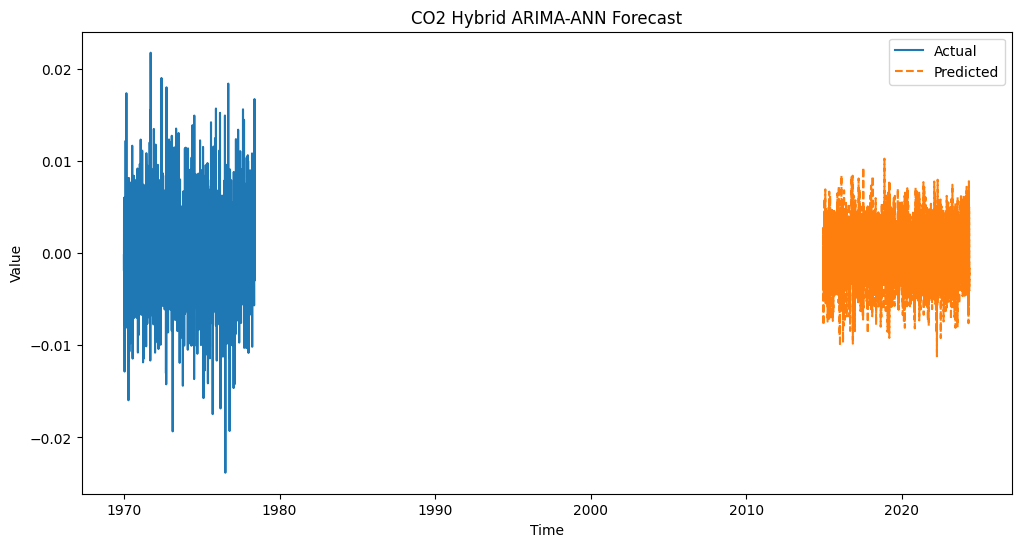

Epoch 1/20


f:\Pythan\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1184
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1067 
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1234 
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1253 
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1270 
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1162 
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1234 
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1254 
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1137 
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1156 
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1238 
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1235 
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1192 
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1210 
Epoch 15/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1119 
Epoch 16/20
10/1

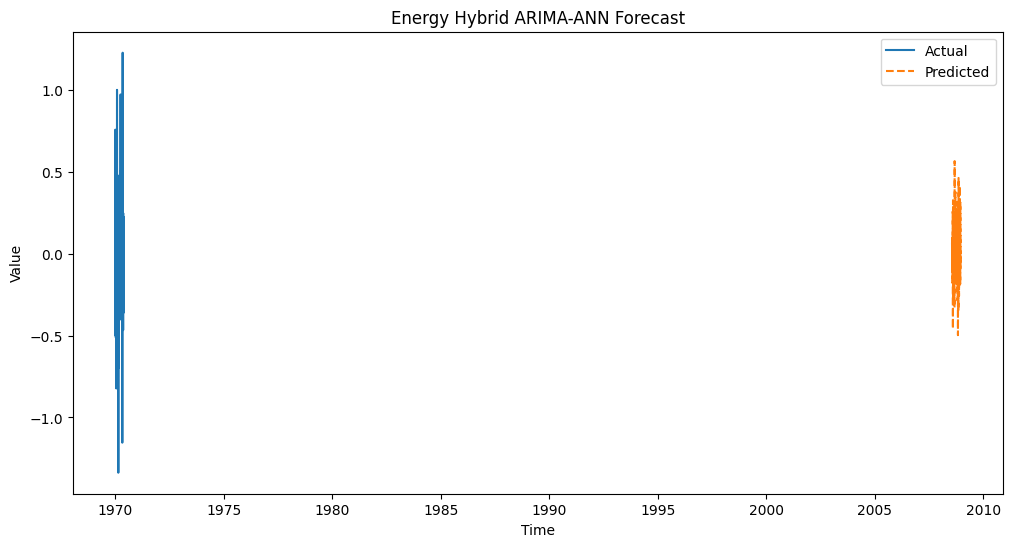

f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Epoch 1/20


f:\Pythan\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0046
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 
Epoch 13/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 
Epoch 14/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 
Epoch 15/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 
Epoch 16/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

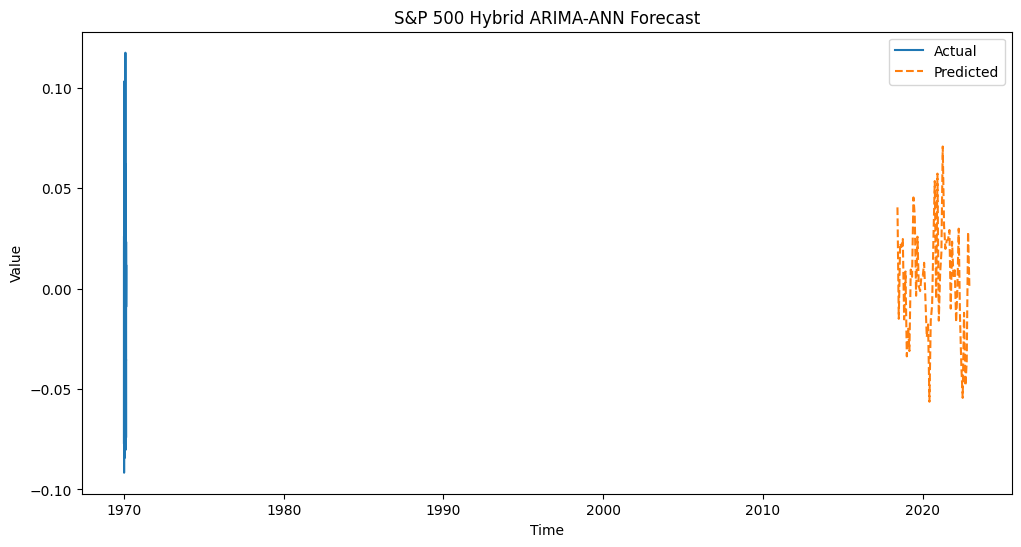

In [21]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Load data (update file paths as needed)
co2_data = pd.read_csv('Co2.csv')
energy_data = pd.read_csv('Energy.csv')
sp500_data = pd.read_csv('sp500_data.csv')

# Preprocessing
# CO2 Data
co2_data['Date'] = pd.to_datetime(co2_data[['Year', 'Month', 'Day']])
co2_data.set_index('Date', inplace=True)

# Energy Data
energy_data['Datetime'] = pd.to_datetime(energy_data['Date'] + ' ' + energy_data['Time'], format='%d/%m/%Y %H:%M:%S')
energy_data.drop(columns=['Date', 'Time'], inplace=True)
energy_data.set_index('Datetime', inplace=True)
for col in energy_data.columns:
    energy_data[col] = pd.to_numeric(energy_data[col], errors='coerce')

# S&P 500 Data
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'], format='%d/%m/%Y')
sp500_data.set_index('Date', inplace=True)

# Handle missing values
energy_data.interpolate(method='time', inplace=True)
energy_data.fillna(method='ffill', inplace=True)
energy_data.fillna(method='bfill', inplace=True)

# Scaling
minmax_scaler = MinMaxScaler()
std_scaler = StandardScaler()

# CO2 Data Scaling
scaler = MinMaxScaler()
co2_data['CO2_ppm_scaled'] = scaler.fit_transform(co2_data[['CO2_ppm']])

# S&P 500 Data Scaling
sp500_data[['Open_scaled', 'High_scaled', 'Low_scaled', 'Close_scaled', 'Adj Close_scaled', 'Volume_scaled']] = \
    minmax_scaler.fit_transform(sp500_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])

# Energy Data Scaling
energy_data[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
             'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']] = \
    std_scaler.fit_transform(energy_data[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
                                         'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']])

energy_data_daily = energy_data.resample('D').mean()

# Function to check stationarity
def test_stationarity(ts):
    adf_result = adfuller(ts)
    return {
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Stationary': adf_result[1] < 0.05
    }

# CO2 Data - Log Transformation and Differencing
co2_data['CO2_ppm_log'] = np.log(co2_data['CO2_ppm_scaled'] + 1)
co2_data['CO2_ppm_diff'] = co2_data['CO2_ppm_log'].diff().dropna()
co2_stationarity = test_stationarity(co2_data['CO2_ppm_diff'].dropna())

# Energy Data - Log Transformation and Differencing
energy_data_daily['Global_active_power_log'] = np.log(energy_data_daily['Global_active_power'] + 1)
energy_data_daily['Global_active_power_diff'] = energy_data_daily['Global_active_power_log'].diff().dropna()
energy_stationarity = test_stationarity(energy_data_daily['Global_active_power_diff'].dropna())

# S&P 500 Data - Log Transformation and Differencing
sp500_data['Adj Close_log'] = np.log(sp500_data['Adj Close'] + 1)
sp500_data['Adj Close_diff'] = sp500_data['Adj Close_log'].diff().dropna()
sp500_stationarity = test_stationarity(sp500_data['Adj Close_diff'].dropna())

# Function to create and train an ARIMA model
def train_arima_model(df, order):
    model = ARIMA(df, order=order)
    model_fit = model.fit()
    return model_fit

# Function to create and train an ANN model
def train_ann_model(X_train, y_train, input_dim, epochs=20, batch_size=64):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# Function to evaluate and plot the model
def evaluate_hybrid_model(y_true, y_pred, title):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    accuracy = 100 - np.mean(np.abs((y_true - y_pred) / y_true) * 100)

    print(f"{title} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}, Accuracy: {accuracy:.2f}%")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Function to run hybrid model
def run_hybrid_model(df, feature, arima_order, title):
    data_for_arima = df[[feature]].dropna()
    
    # ARIMA model
    arima_model = train_arima_model(data_for_arima, order=arima_order)
    arima_pred = arima_model.predict(start=1, end=len(data_for_arima)-1)  # Ensure consistent length
    residuals = data_for_arima.iloc[1:][feature] - arima_pred
    
    # ANN model for residuals
    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(arima_pred).reshape(-1, 1))
    y = residuals.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    ann_model = train_ann_model(X_train, y_train, input_dim=1)
    ann_pred = ann_model.predict(X_test)
    
    # Combine ARIMA and ANN predictions
    combined_pred = arima_pred[-len(ann_pred):] + ann_pred.flatten()
    evaluate_hybrid_model(y_test, combined_pred, title)

# Run hybrid model for CO2 data
run_hybrid_model(co2_data, 'CO2_ppm_diff', (5, 1, 0), "CO2 Hybrid ARIMA-ANN Forecast")

# Run hybrid model for Energy data
run_hybrid_model(energy_data_daily, 'Global_active_power_diff', (5, 1, 0), "Energy Hybrid ARIMA-ANN Forecast")

# Run hybrid model for S&P 500 data
run_hybrid_model(sp500_data, 'Adj Close_diff', (5, 1, 0), "S&P 500 Hybrid ARIMA-ANN Forecast")


f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base

Epoch 1/50


f:\Pythan\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9850
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0019
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0009
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0138
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9855
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9884
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9663
Epoch 8/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9646
Epoch 9/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9750
Epoch 10/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0062
Epoch 11/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9785
Epoch 12/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9696
Epoch 13/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9882
Epoch 14/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0034
Epoch 15/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9770


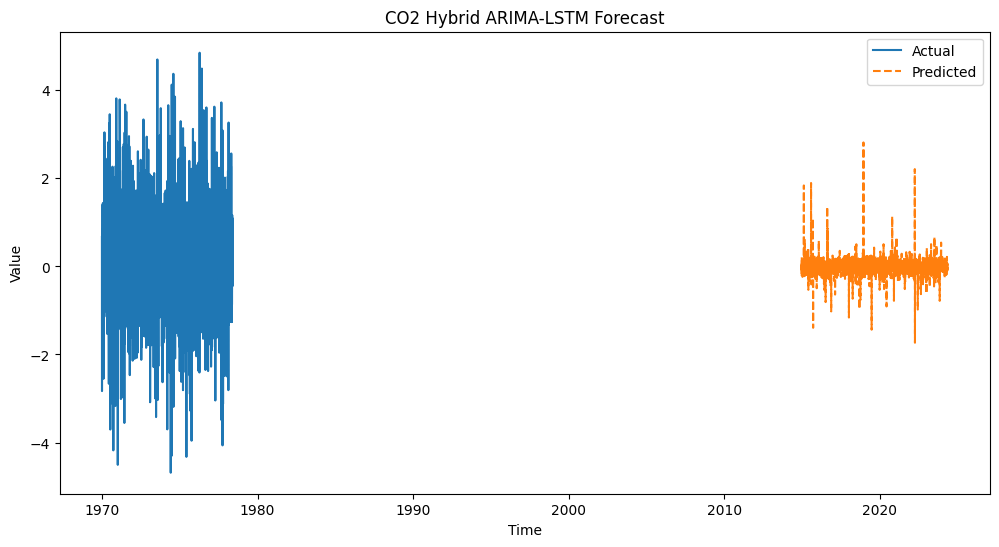

f:\Pythan\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
f:\Pythan\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
f:\Pythan\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
f:\Pythan\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
f:\Pythan\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters fo

Epoch 1/50


f:\Pythan\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
f:\Pythan\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0395
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0636 
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1319 
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9774 
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1156 
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0363 
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1254 
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0367 
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9204 
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0527 
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9888 
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0468 
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0123 
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0410 
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1209 
Epoch 16/50
19/1

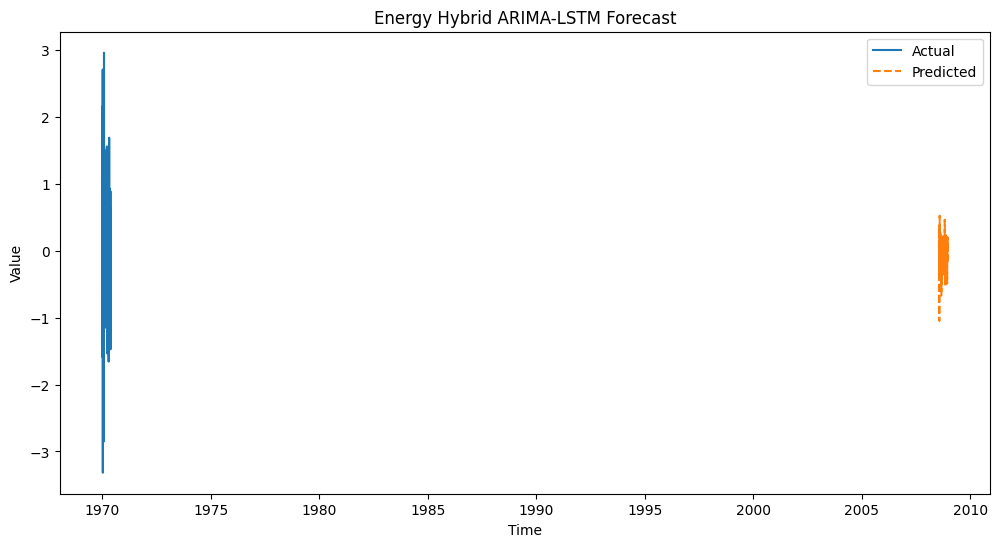

f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
f:\Pythan\lib\site-packages\statsmodels\tsa\b

Epoch 1/50


f:\Pythan\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
f:\Pythan\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0274
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9608 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8626 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0132 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9790 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1617 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0495 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9633 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1319 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9306 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0041 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9217 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9692 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8889 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0783 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

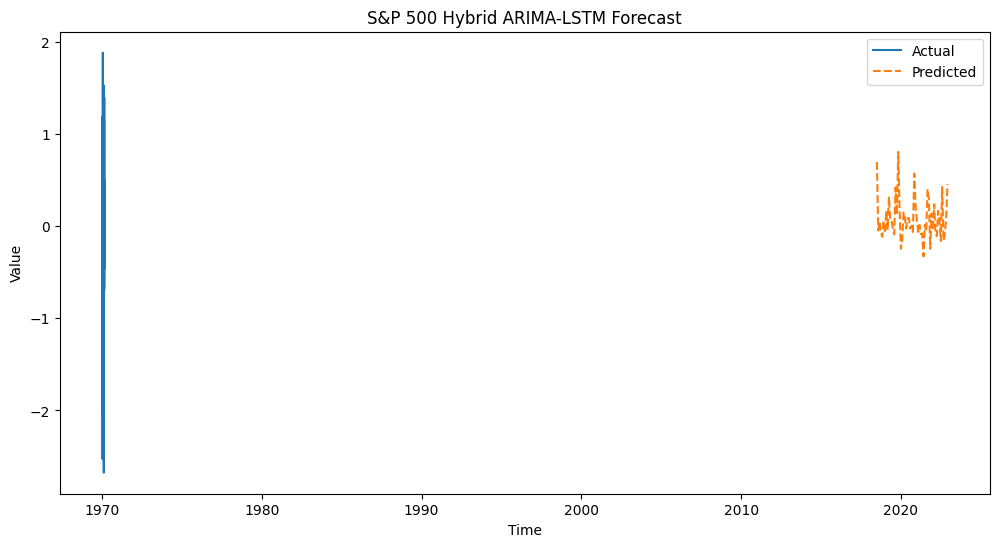

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# ARIMA Hyperparameter Tuning
def train_best_arima_model(df, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(df, order=order)
                    model_fit = model.fit()
                    aic = model_fit.aic
                    if aic < best_score:
                        best_score, best_cfg = aic, order
                except:
                    continue
    return ARIMA(df, order=best_cfg).fit()

# ANN Hyperparameters Tuning with LSTM
def train_lstm_model(X_train, y_train, input_dim, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(input_dim, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# Windowing for ANN
def create_windowed_data(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df[i:i+window_size])
        y.append(df[i+window_size])
    return np.array(X), np.array(y)

# Function to evaluate and plot the model
def evaluate_hybrid_model(y_true, y_pred, title):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    accuracy = 100 - np.mean(np.abs((y_true - y_pred) / y_true) * 100)

    print(f"{title} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}, Accuracy: {accuracy:.2f}%")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Function to run hybrid model
# Updated version of the run_hybrid_model function
def run_hybrid_model(df, feature, p_values, d_values, q_values, title):
    data_for_arima = df[[feature]].dropna()
    
    # ARIMA model
    arima_model = train_best_arima_model(data_for_arima, p_values, d_values, q_values)
    arima_pred = arima_model.predict(start=1, end=len(data_for_arima) - 1)
    residuals = data_for_arima.iloc[1:][feature] - arima_pred

    # ANN model for residuals
    scaler = StandardScaler()
    residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))
    window_size = 5  # Adjustable window size for ANN input
    X, y = create_windowed_data(residuals_scaled, window_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lstm_model = train_lstm_model(X_train, y_train, input_dim=window_size)
    ann_pred = lstm_model.predict(X_test)

    # Adjusting arima_pred to have the same length as ann_pred
    arima_pred_trimmed = arima_pred[-len(ann_pred):]

    # Combine ARIMA and ANN predictions
    combined_pred = arima_pred_trimmed + ann_pred.flatten()
    evaluate_hybrid_model(y_test.flatten(), combined_pred, title)


# Run hybrid models with tuned ARIMA and LSTM on datasets
# Specify p, d, q values to search
p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3, 4, 5]

# Example usage (update data preparation code accordingly)
run_hybrid_model(co2_data, 'CO2_ppm_diff', p_values, d_values, q_values, "CO2 Hybrid ARIMA-LSTM Forecast")
run_hybrid_model(energy_data_daily, 'Global_active_power_diff', p_values, d_values, q_values, "Energy Hybrid ARIMA-LSTM Forecast")
run_hybrid_model(sp500_data, 'Adj Close_diff', p_values, d_values, q_values, "S&P 500 Hybrid ARIMA-LSTM Forecast")
